# Bibliotecas

In [1]:
import math
import os
import re
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from datetime import timedelta
from sklearn.cluster import KMeans
from random import randint
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from timeit import default_timer as timer

%run ./pca_library.ipynb
%run ./base_functions.ipynb

pd.options.mode.chained_assignment = None # desabilita warnings de SettingWithCopyWarning
plt.rcParams.update({'figure.max_open_warning': 0}) # desabilita warning para plot de mais de 20 figuras

In [2]:
# Caminho no qual as imagens geradas serão salvas quando exportadas
saving_path = r"C:\Users\anaso\Desktop\workspace\doutorado\imagens"

# Funções

In [3]:
def print_overview(data):
    
    """
    Retorna algumas informações gerais sobre o banco de dados, como existência de nulos e duplicatas, dentre outros.
    """
    
    # Shape do banco
    print("Shape do banco: ", data.shape)
    
    # Alguma linha com todos os valores zerados?
    zero_rows = data.index[(data==0).all(axis=1)].tolist()
    print("\nQuantidade de linhas zeradas: ", len(zero_rows))
    
    # Existem nulos?
    print("Quantidade de nulos no banco: ", data.isnull().sum().sum())
    
    # Há duplicatas baseado no timestamp?
    qtd_duplis = len(data[data.duplicated(['timestamp'])])
    if (qtd_duplis > 0):
        print("Quantidade de duplicatas: ", qtd_duplis)
#         print(data[data.duplicated(['timestamp'])])
    else:
        print("\nNão há registros duplicados.")
    
    print()
    
    # Alguma coluna possui um único valor constante?
    single_values_columns = []
    for col in (data.columns):
        unique_values = data[col].nunique()
        if (unique_values == 1):
            single_values_columns.append(col)
    if len(single_values_columns) > 0:
        print("Existem " + str(len(single_values_columns)) + " colunas constantes. São elas: " + str(single_values_columns))
    else:
        print("Não há colunas constantes.")
    
    # Alguma linha inteiramente zerada?
    data_sem_dt = data.drop(['timestamp'], 1)
    zero_rows = data_sem_dt.index[(data_sem_dt == 0).all(axis=1)].tolist()
    if len(zero_rows) > 0:
        print("Existem " + str(len(zero_rows)) + " linhas inteiramente zeradas.")
    else:
        print("Não há linhas inteiramente zeradas.")
    
    # Alguma linha com todas as colunas NaN?
    nan_rows = data.index[(data == float('nan')).all(axis=1)].tolist()
    if len(nan_rows) > 0:
        print("Existem " + str(len(nan_rows)) + " instâncias sem registro.")
    else:
        print("Não há linhas inteiramente sem registro (nan).")

In [4]:
def fault_cluster(dataset, fault_id, days_to_count, clusters):
    
    init_nota = fault_log.loc[fault_log['ID'] == fault_id]['InicioAvar'].reset_index().iloc[0,1]
    pre_falha = init_nota - timedelta(days=days_to_count)

    fim_ordem = fault_log.loc[fault_log['ID'] == fault_id]['Dt.real fim'].reset_index().iloc[0,1]
    fim_ordem = datetime.datetime.combine(fim_ordem, datetime.time.max) # define a última hora possível (23:59)
    pos_manut = fim_ordem + timedelta(days=days_to_count) 

    fault_data = dataset.loc[(dataset['timestamp'] >= pre_falha) & (dataset['timestamp'] <= pos_manut)]

    fault_data_scaled = preprocessing.scale(fault_data.drop(['timestamp','rotulos_multi','rotulos_bin'], 1))
    
    kmeans = KMeans(n_clusters=clusters, max_iter=1000, random_state=0).fit(fault_data_scaled)
    x_clustered = kmeans.fit_predict(fault_data_scaled)
    
    return x_clustered, fault_data, init_nota, fim_ordem

In [5]:
def plot_cluster(fault_data, x_clustered, var, init_nota, fim_ordem):
    
    fault_data['clusters'] = x_clustered
    min_lim = fault_data[var].min()-500
    max_lim = fault_data[var].max()+500
    
    n_clusters = len(np.unique(x_clustered))
    colors_list = ['red', 'blue', 'green']
    count = 0
    colors_dict = {}

    for i in range(n_clusters):
        colors_dict[i] = colors_list[i]
        count+=1
    
    label_color = [colors_dict[l] for l in x_clustered]
    
    plt.figure(figsize=(15,3))
    plt.plot(fault_data['timestamp'], fault_data[var], marker='o', linestyle='None')
    plt.xlim([fault_data['timestamp'].min(), fault_data['timestamp'].max()])
    plt.axvline(x=init_nota, color='red', linestyle='--', label='Inicio NOTA')
    plt.axvline(x=fim_ordem, color='blue', linestyle='--', label='Fim ORDEM')
    plt.ylim([min_lim, max_lim])
    plt.show()

    plt.figure(figsize=(15,3))
    plt.plot(fault_data.query("clusters == 0")['timestamp'], fault_data.query("clusters == 0")[var], \
             colors_dict[0], marker='o', linestyle='None', label='CLUSTER 01')
    plt.xlim([fault_data['timestamp'].min(), fault_data['timestamp'].max()])
    plt.axvline(x=init_nota, color='red', linestyle='--', label='Inicio NOTA')
    plt.axvline(x=fim_ordem, color='blue', linestyle='--', label='Fim ORDEM')
    plt.ylim([min_lim, max_lim])
    plt.legend(loc='upper left')
    plt.show()

    plt.figure(figsize=(15,3))
    plt.plot(fault_data.query("clusters == 1")['timestamp'], fault_data.query("clusters == 1")[var], \
             colors_dict[1], marker='o', linestyle='None', label='CLUSTER 02')
    plt.xlim([fault_data['timestamp'].min(), fault_data['timestamp'].max()])
    plt.axvline(x=init_nota, color='red', linestyle='--', label='Inicio NOTA')
    plt.axvline(x=fim_ordem, color='blue', linestyle='--', label='Fim ORDEM')
    plt.ylim([min_lim, max_lim])
    plt.legend(loc='upper left')
    plt.show()

    if (n_clusters == 3):
        plt.figure(figsize=(15,3))
        plt.plot(fault_data.query("clusters == 2")['timestamp'], fault_data.query("clusters == 2")[var], colors_dict[2], marker='o', linestyle='None')
        plt.xlim([fault_data['timestamp'].min(), fault_data['timestamp'].max()])
        plt.axvline(x=init_nota, color='red', linestyle='--', label='Inicio NOTA')
        plt.axvline(x=fim_ordem, color='blue', linestyle='--', label='Fim ORDEM')
        plt.ylim([min_lim, max_lim])
        plt.show()

# Leitura dos arquivos

In [6]:
data = pd.read_csv(r"D:\Caso 2 - Bomba Centrífuga\final_data.csv", sep=';')
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [7]:
fault_log = pd.read_excel("D:\Caso 2 - Bomba Centrífuga\Bancos tratados\Falhas_Bomba_final_v0.xlsx")

fault_log['InicioAvar'] = pd.to_datetime(fault_log['InicioAvar'])
fault_log['Dt.real fim'] = pd.to_datetime(fault_log['Dt.real fim'])

# Remoção das falhas não marcadas - longas ou contidas em outras falhas
fault_log = fault_log.dropna(subset=['Filtro'])

In [8]:
# Informações gerais sobre o banco

print_overview(data)

Shape do banco:  (1435326, 26)

Quantidade de linhas zeradas:  0
Quantidade de nulos no banco:  0

Não há registros duplicados.

Não há colunas constantes.
Não há linhas inteiramente zeradas.
Não há linhas inteiramente sem registro (nan).


# Banco 1 - Rótulos via OMs

In [9]:
labeled_data = data.copy()

labeled_data['rotulos_multi'] = np.zeros(())
labeled_data['rotulos_bin'] = np.zeros(())

In [10]:
for i in range(len(fault_log)):
    
    ID = fault_log.iloc[i]['ID']
    
    print("\n--------------------------------------------------------------------------------")
    print("Falha ", (ID))

    init_falha = fault_log.iloc[i]['InicioAvar']
    init_falha = datetime.datetime.combine(init_falha, datetime.time.min)

    end_falha = fault_log.iloc[i]['Dt.real fim']
    end_falha = datetime.datetime.combine(end_falha, datetime.time.max)

    df_fault_final = labeled_data.loc[((labeled_data["timestamp"] >= init_falha) & 
                                       (labeled_data["timestamp"] <= end_falha))]
    elapsed_time = end_falha - init_falha

    print("Dias:  ", elapsed_time.days)
    print("Horas: ", divmod(elapsed_time.total_seconds(), 3600)[0])
    print("Instâncias: ", len(df_fault_final))

    if (len(df_fault_final) == 0):
        print("Falha " + str(ID) + " não existe!")
    else:
        labeled_data.loc[
            ((labeled_data["timestamp"] >= init_falha) & (labeled_data["timestamp"] <= end_falha)), 'rotulos_multi'] = ID

        labeled_data.loc[
            ((labeled_data["timestamp"] >= init_falha) & (labeled_data["timestamp"] <= end_falha)), 'rotulos_bin'] = 1

    print("Init falha: ", labeled_data.loc[labeled_data['rotulos_multi'] == ID]['timestamp'].min())
    print("End falha : ", labeled_data.loc[labeled_data['rotulos_multi'] == ID]['timestamp'].max())
    print("\nReal:")
    print("Init falha: ", init_falha)
    print("End falha : ", end_falha)


--------------------------------------------------------------------------------
Falha  1
Dias:   2
Horas:  71.0
Instâncias:  726
Init falha:  2011-05-22 11:54:00
End falha :  2011-05-22 23:59:00

Real:
Init falha:  2011-05-20 00:00:00
End falha :  2011-05-22 23:59:59.999999

--------------------------------------------------------------------------------
Falha  2
Dias:   18
Horas:  455.0
Instâncias:  5717
Init falha:  2011-07-02 00:00:00
End falha :  2011-07-07 18:47:00

Real:
Init falha:  2011-07-02 00:00:00
End falha :  2011-07-20 23:59:59.999999

--------------------------------------------------------------------------------
Falha  4
Dias:   3
Horas:  95.0
Instâncias:  0
Falha 4 não existe!
Init falha:  NaT
End falha :  NaT

Real:
Init falha:  2011-09-03 00:00:00
End falha :  2011-09-06 23:59:59.999999

--------------------------------------------------------------------------------
Falha  5
Dias:   19
Horas:  479.0
Instâncias:  25469
Init falha:  2012-04-12 00:00:00
End falha : 

In [11]:
Counter(labeled_data['rotulos_multi'])

Counter({0.0: 770855,
         1.0: 726,
         2.0: 5717,
         6.0: 232665,
         7.0: 26067,
         8.0: 1351,
         9.0: 14850,
         10.0: 8301,
         11.0: 285146,
         17.0: 2757,
         18.0: 13413,
         19.0: 4,
         20.0: 10656,
         24.0: 34503,
         25.0: 28297,
         27.0: 18})

In [12]:
Counter(labeled_data['rotulos_bin'])

Counter({0.0: 770855, 1.0: 664471})

### K-Means

In [13]:
x_data = labeled_data.drop(['timestamp','rotulos_multi','rotulos_bin'], axis=1)

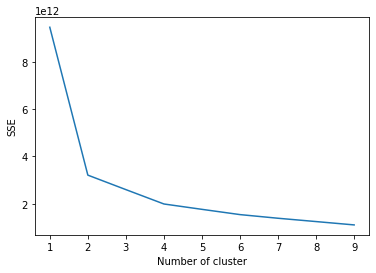

In [14]:
sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(x_data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(x_data)
X_clustered = kmeans.fit_predict(x_data)

In [16]:
results = labeled_data[['rotulos_bin','rotulos_multi']].copy()
results['clusterNumber'] = X_clustered
results.head()

,rotulos_bin,rotulos_multi,clusterNumber
0,0.0,0.0,0
1,0.0,0.0,0
2,0.0,0.0,0
3,0.0,0.0,0
4,0.0,0.0,0


In [17]:
Counter(results['clusterNumber'])

Counter({0: 1419214, 1: 16112})

- A classe 0 do k-means parece ser a classe referente às falhas, uma vez que todas as falhas rotuladas constam na listagem, apesar de períodos de operação normal também estarem presentes.
- Na segunda classe (1), que imagino se referir à operação normal, trechos das falhas longas 6, 11, 20 e 24 estão presentes. Isto pode indicar erros nos períodos informados. Me leva a crer que não deveriam ser tão longos assim. 

In [15]:
print(results.query("clusterNumber == 0")['rotulos_multi'].unique())
print(results.query("clusterNumber == 1")['rotulos_multi'].unique())

[ 0.  1.  2.  6.  7.  8.  9. 10. 11. 17. 18. 19. 20. 24. 25. 27.]
[ 0.  6.  8.  9. 11. 17. 20. 25. 24.]


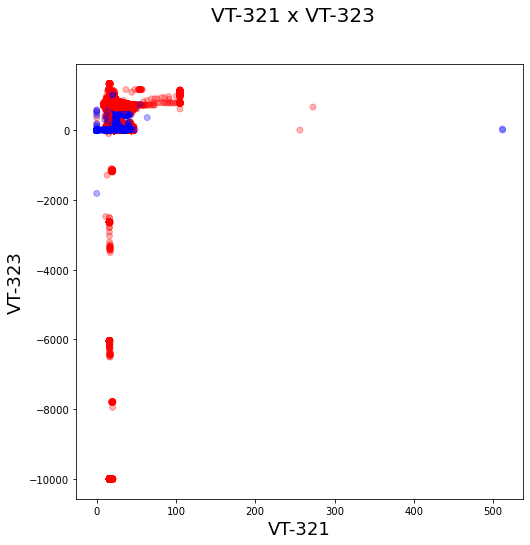

In [16]:
LABEL_COLOR_MAP = {0 : 'red', 1 : 'blue'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

c1 = 0 
c2 = 1
features = ['VT-321', 'VT-323']
c1feature = features[c1]
c2feature = features[c2]
title = features[c1] + ' x ' + features[c2]

plt.figure(figsize=(8,8))
plt.scatter(x_data.iloc[:, c1], x_data.iloc[:, c2], c=label_color, alpha=0.3) 
plt.xlabel(c1feature, fontsize=18)
plt.ylabel(c2feature, fontsize=18)
plt.suptitle(title, fontsize=20)
# plt.savefig(title + '.jpg')
plt.show()


-----------------------------------------------------------------------------------------------------------
Falha  1.0
Clusters:  [0]


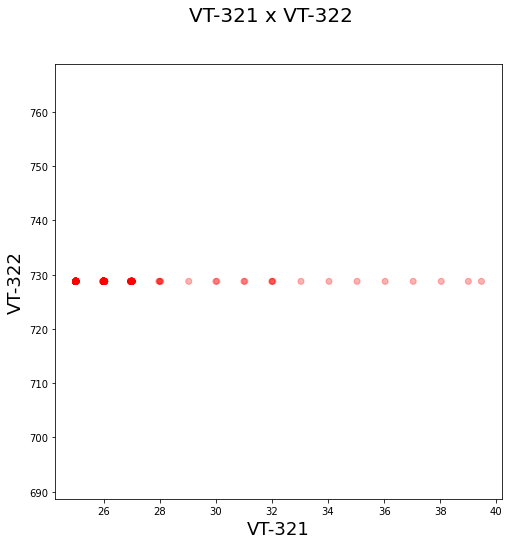


-----------------------------------------------------------------------------------------------------------
Falha  2.0
Clusters:  [0]


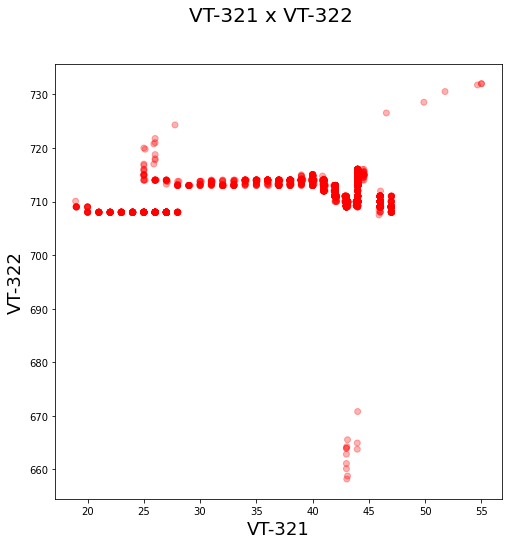


-----------------------------------------------------------------------------------------------------------
Falha  6.0
Clusters:  [0 1]


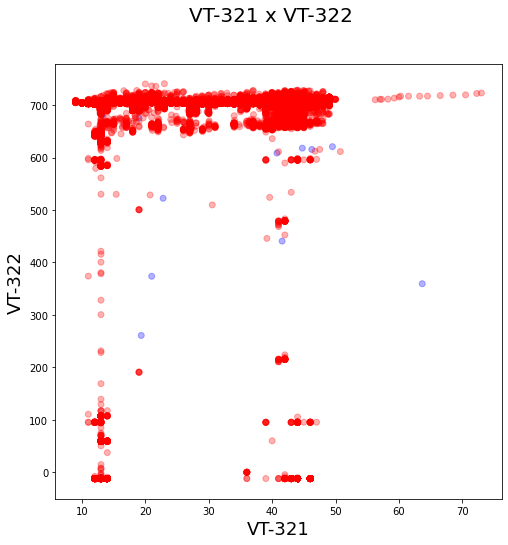


-----------------------------------------------------------------------------------------------------------
Falha  7.0
Clusters:  [0]


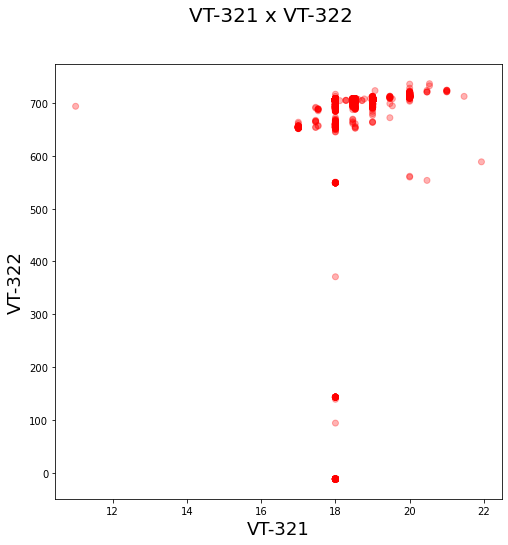


-----------------------------------------------------------------------------------------------------------
Falha  8.0
Clusters:  [0 1]


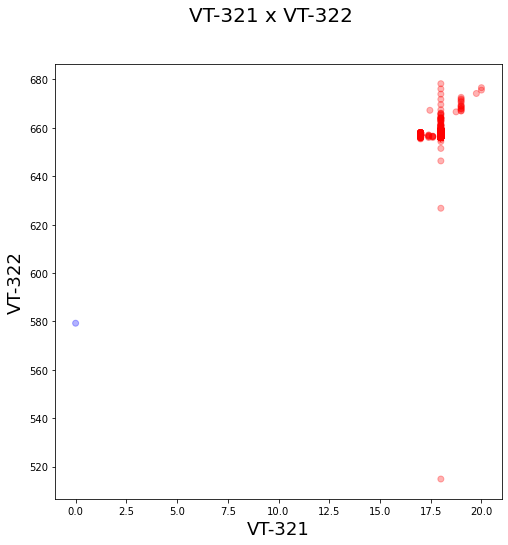


-----------------------------------------------------------------------------------------------------------
Falha  9.0
Clusters:  [0 1]


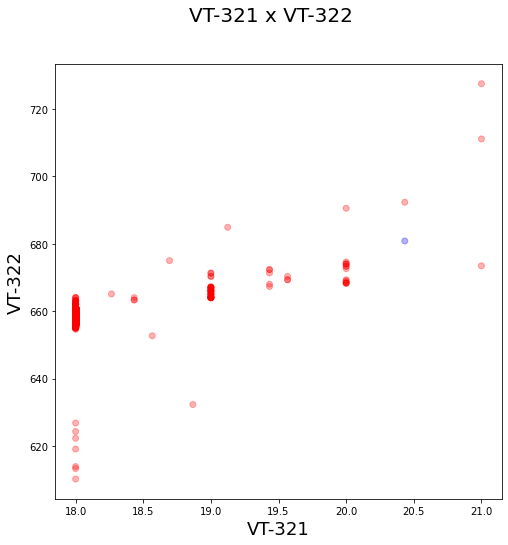


-----------------------------------------------------------------------------------------------------------
Falha  10.0
Clusters:  [0]


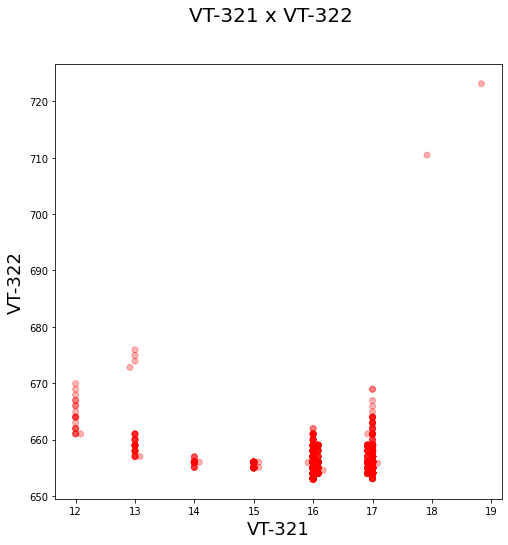


-----------------------------------------------------------------------------------------------------------
Falha  11.0
Clusters:  [0 1]


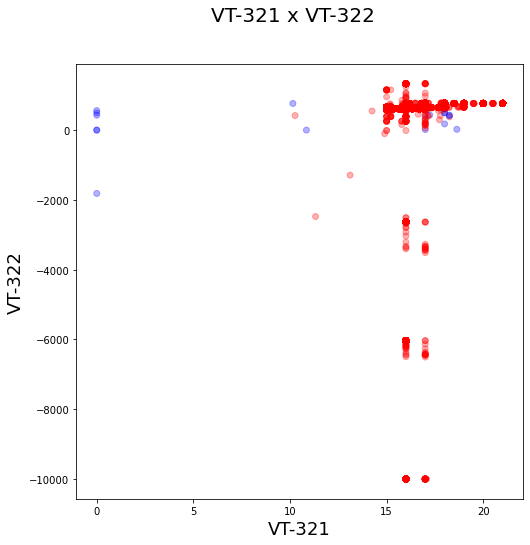


-----------------------------------------------------------------------------------------------------------
Falha  17.0
Clusters:  [0 1]


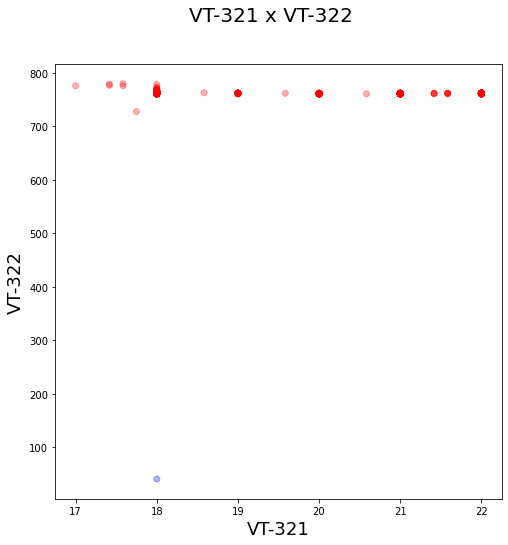


-----------------------------------------------------------------------------------------------------------
Falha  18.0
Clusters:  [0]


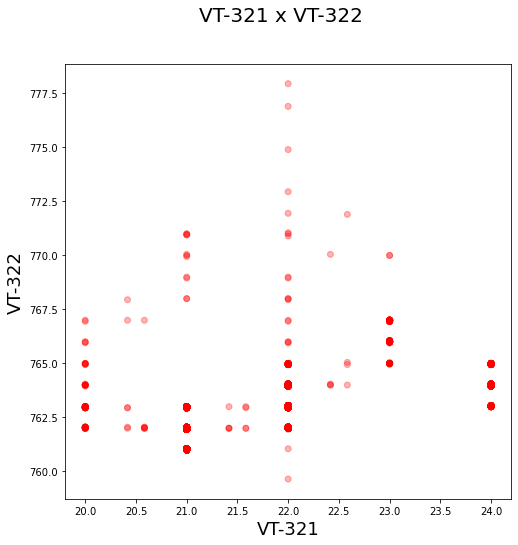


-----------------------------------------------------------------------------------------------------------
Falha  19.0
Clusters:  [0]


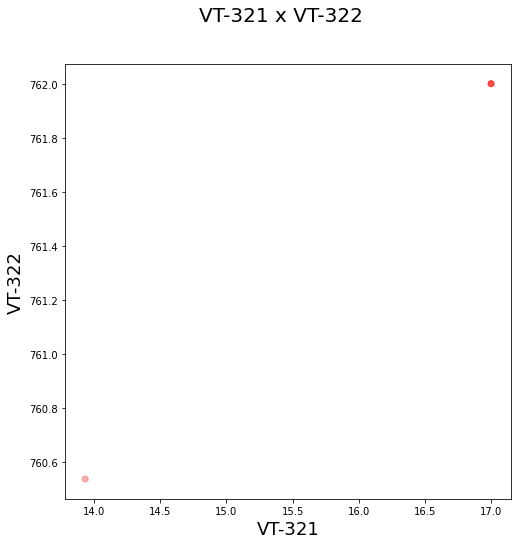


-----------------------------------------------------------------------------------------------------------
Falha  20.0
Clusters:  [1 0]


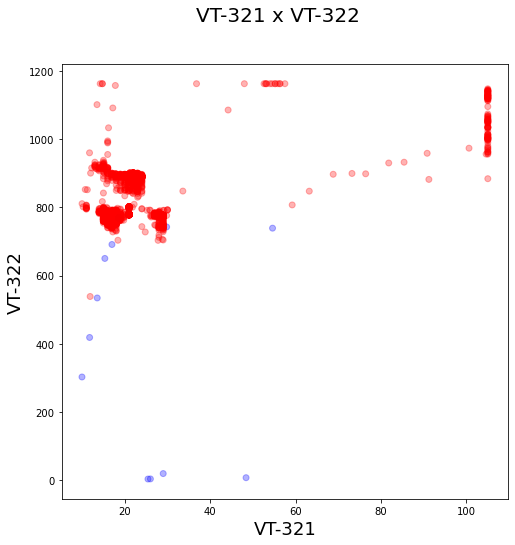


-----------------------------------------------------------------------------------------------------------
Falha  24.0
Clusters:  [0 1]


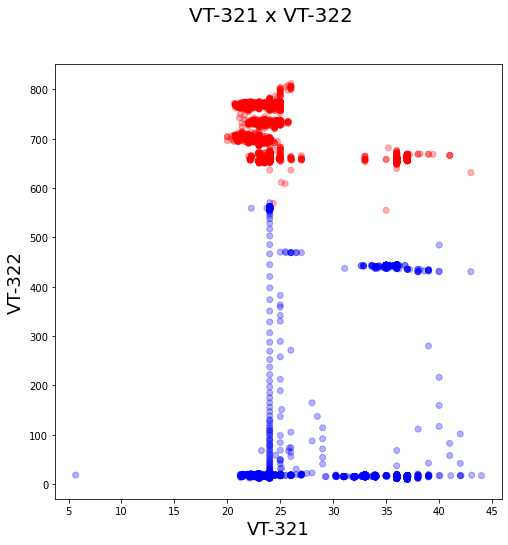


-----------------------------------------------------------------------------------------------------------
Falha  25.0
Clusters:  [0 1]


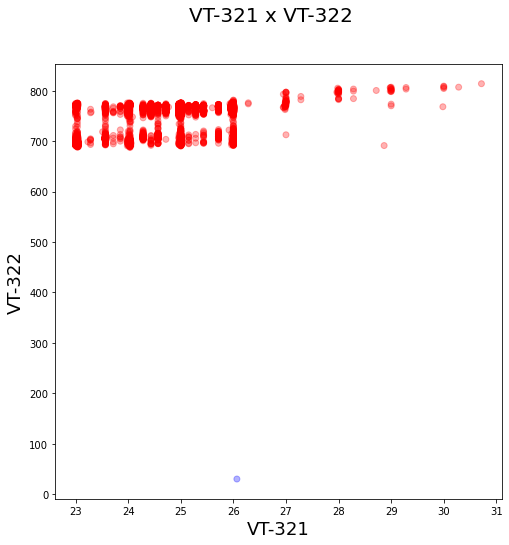


-----------------------------------------------------------------------------------------------------------
Falha  27.0
Clusters:  [0]


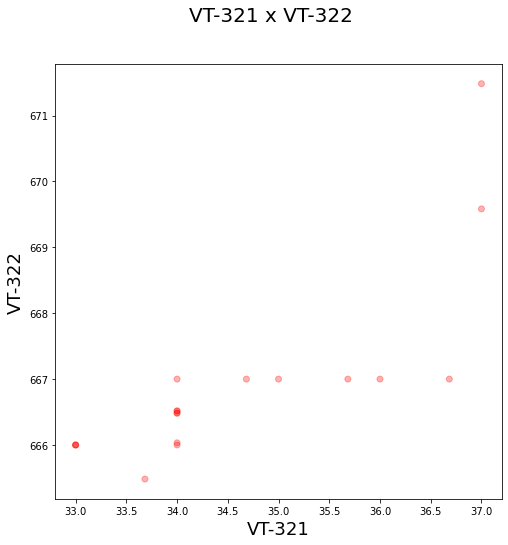

In [36]:
x_data_labeled = pd.concat([x_data, results], axis=1)
x_data_labeled.shape

LABEL_COLOR_MAP = {0 : 'red', 1 : 'blue'}
# label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

c1 = 0 
c2 = 1
features = ['VT-321', 'VT-322']
c1feature = features[c1]
c2feature = features[c2]
title = features[c1] + ' x ' + features[c2]

for fault in results.rotulos_multi.unique()[1:]:

    print("\n-----------------------------------------------------------------------------------------------------------")
    print("Falha ", fault)

    data_fault = x_data_labeled[x_data_labeled['rotulos_multi'] == fault].copy()
    print("Clusters: ", data_fault['clusterNumber'].unique())
    label_color = [LABEL_COLOR_MAP[l] for l in data_fault['clusterNumber']]
    
    plt.figure(figsize=(8,8))
    plt.scatter(data_fault.iloc[:, c1], data_fault.iloc[:, c2], c=label_color, alpha=0.3) 
    plt.xlabel(c1feature, fontsize=18)
    plt.ylabel(c2feature, fontsize=18)
    plt.suptitle(title, fontsize=20)
    # plt.savefig(title + '.jpg')
    plt.show()


-----------------------------------------------------------------------------------------------------------
1.0


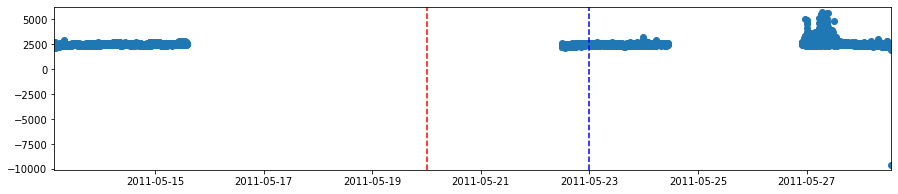

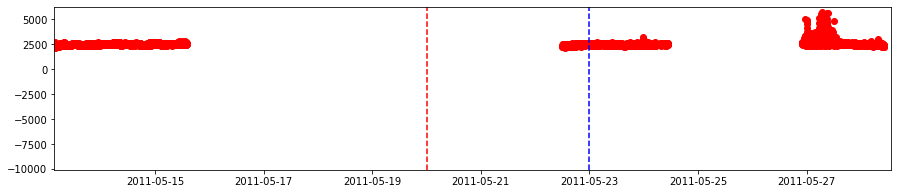

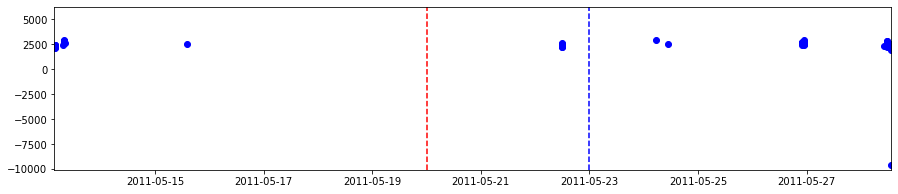


-----------------------------------------------------------------------------------------------------------
2.0


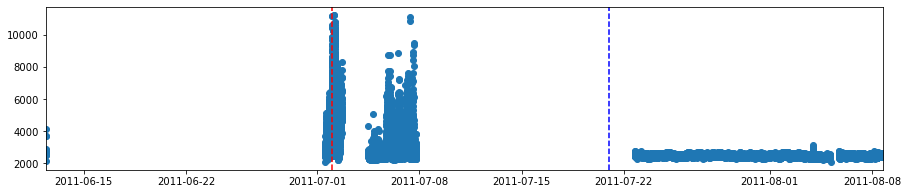

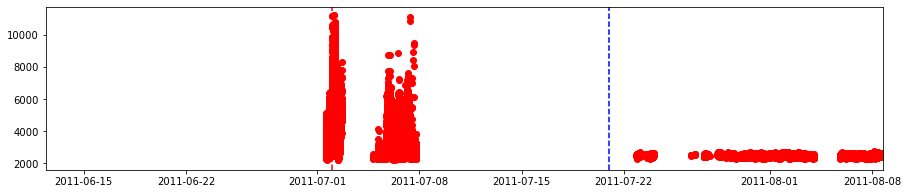

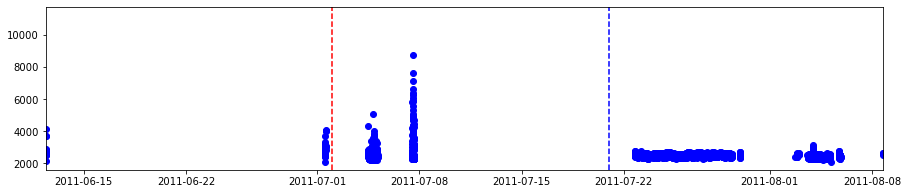


-----------------------------------------------------------------------------------------------------------
6.0


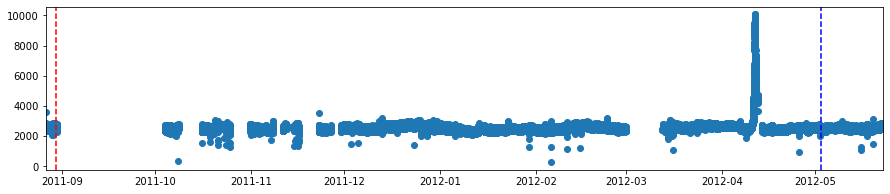

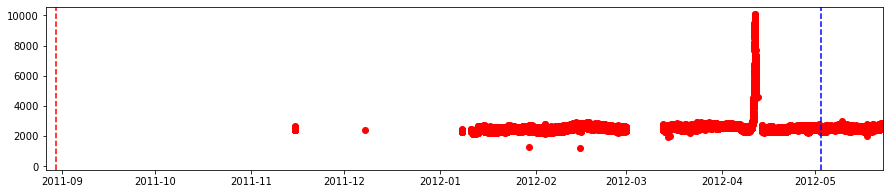

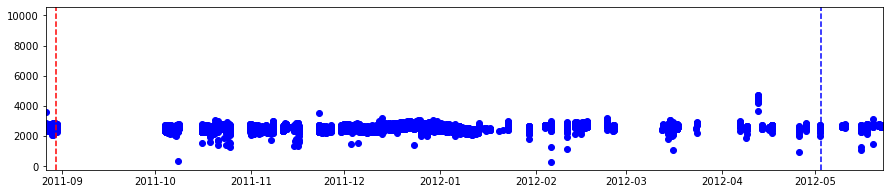


-----------------------------------------------------------------------------------------------------------
7.0


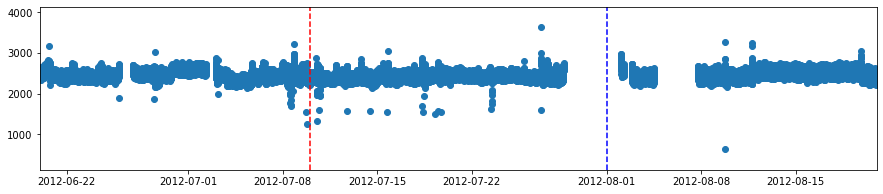

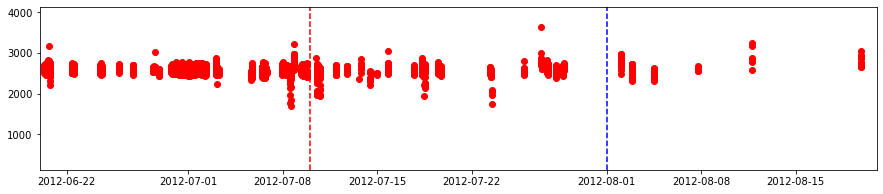

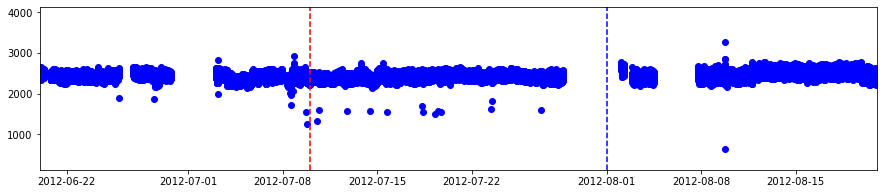


-----------------------------------------------------------------------------------------------------------
8.0


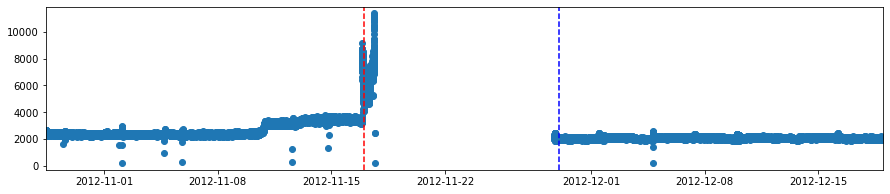

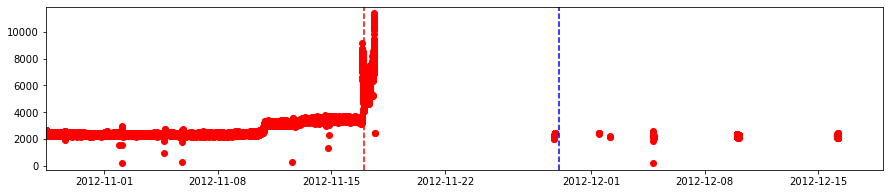

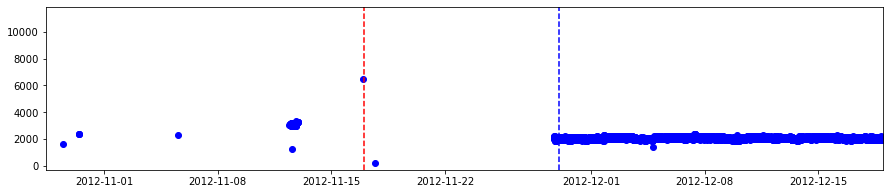


-----------------------------------------------------------------------------------------------------------
9.0


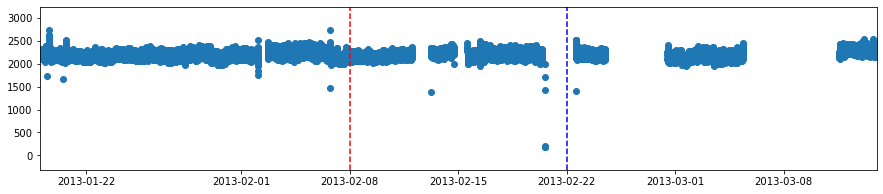

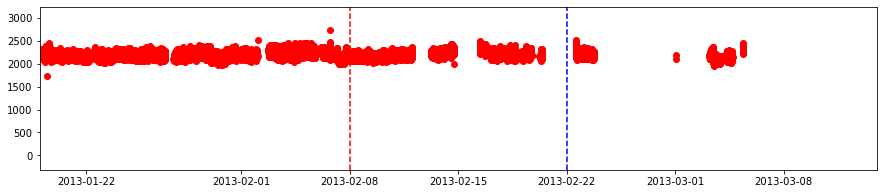

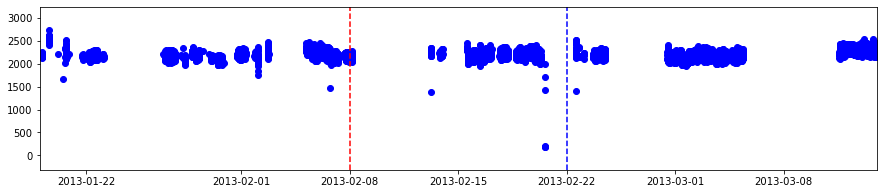


-----------------------------------------------------------------------------------------------------------
10.0


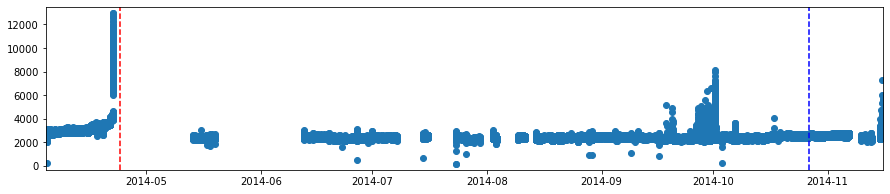

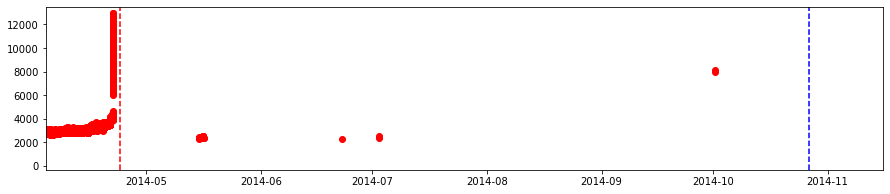

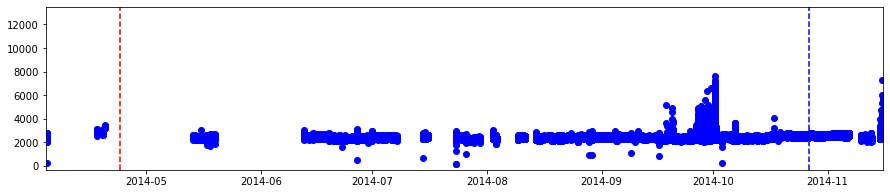


-----------------------------------------------------------------------------------------------------------
11.0


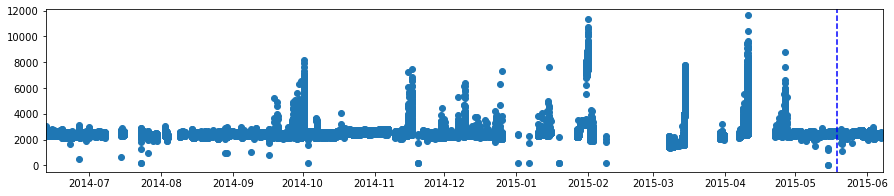

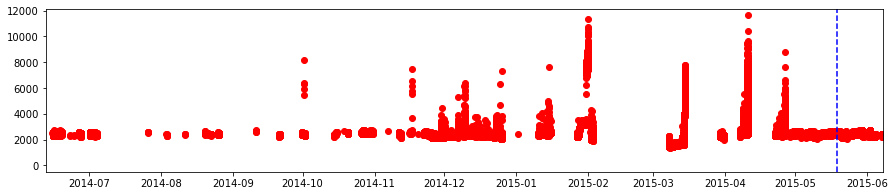

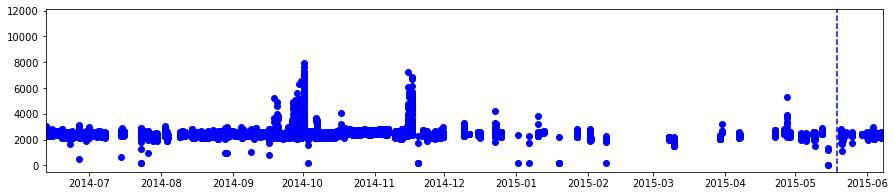


-----------------------------------------------------------------------------------------------------------
17.0


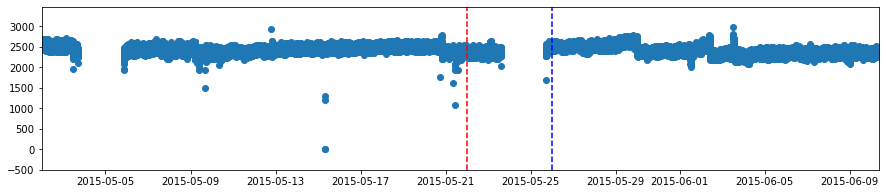

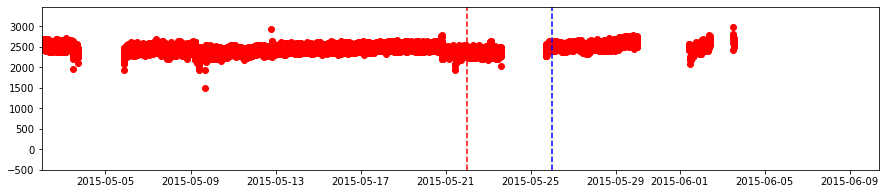

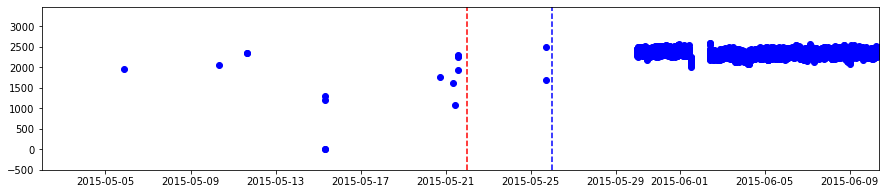


-----------------------------------------------------------------------------------------------------------
18.0


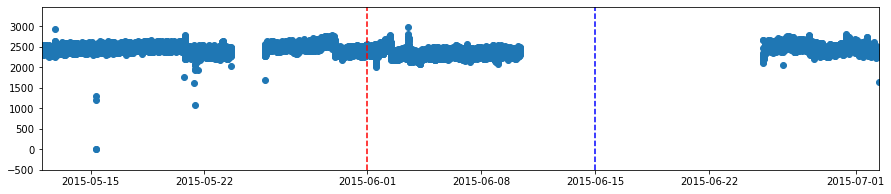

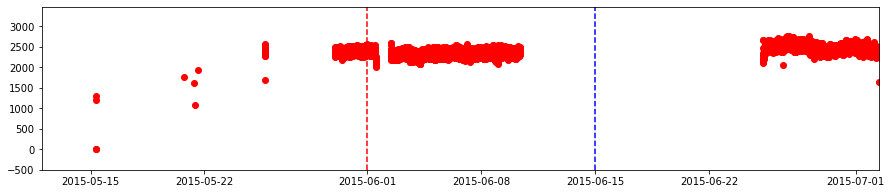

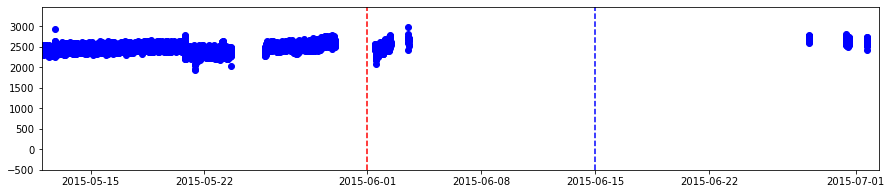


-----------------------------------------------------------------------------------------------------------
19.0


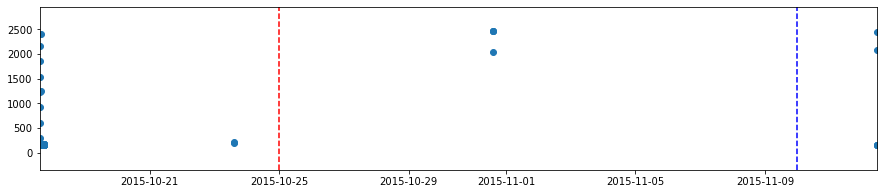

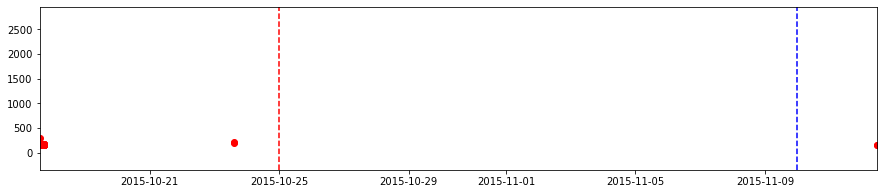

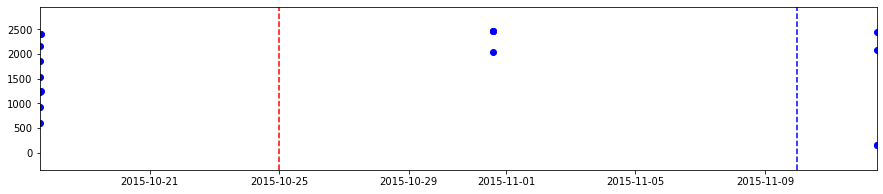


-----------------------------------------------------------------------------------------------------------
20.0


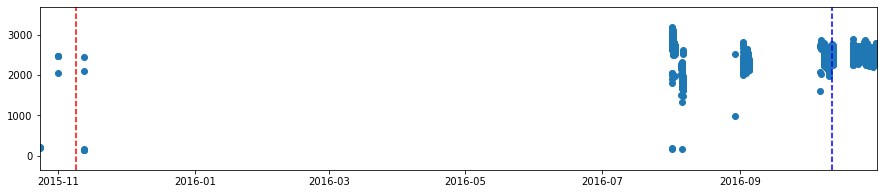

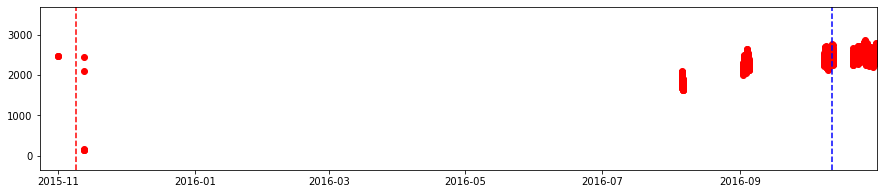

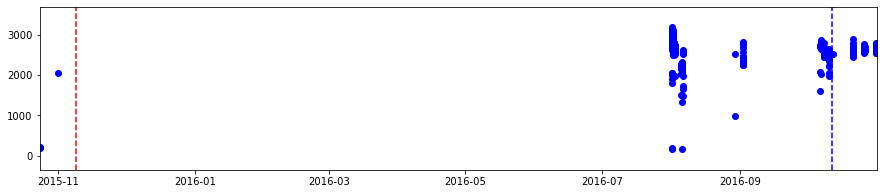


-----------------------------------------------------------------------------------------------------------
24.0


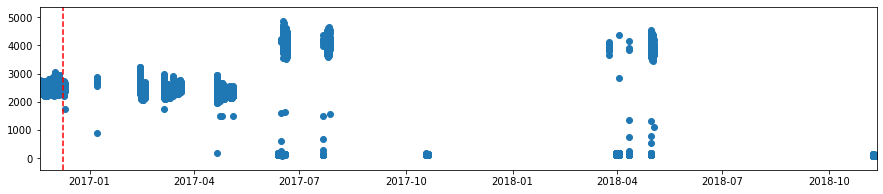

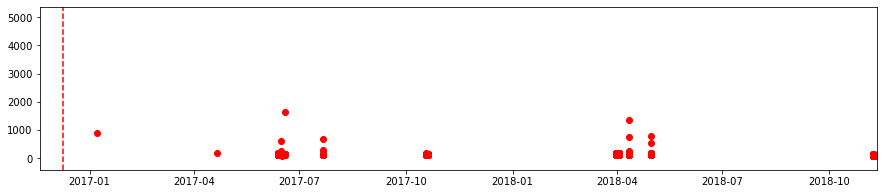

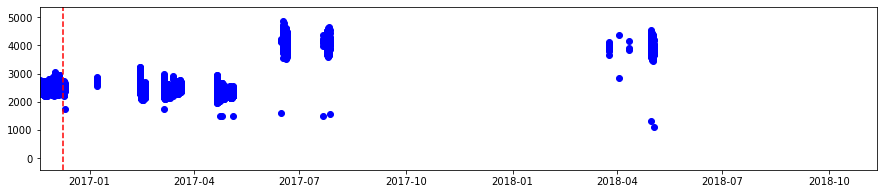


-----------------------------------------------------------------------------------------------------------
25.0


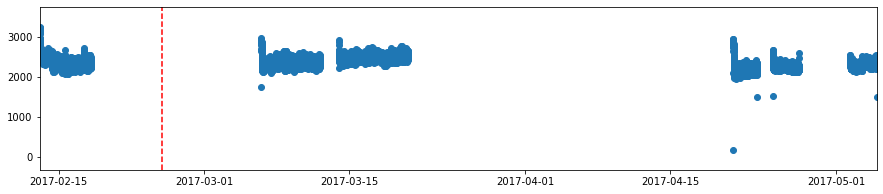

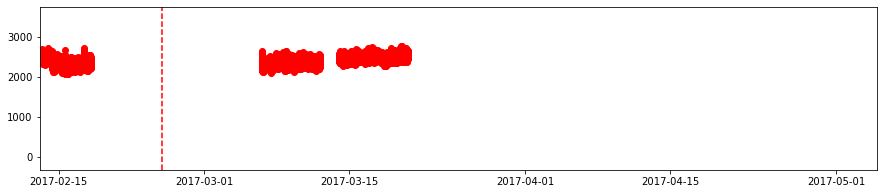

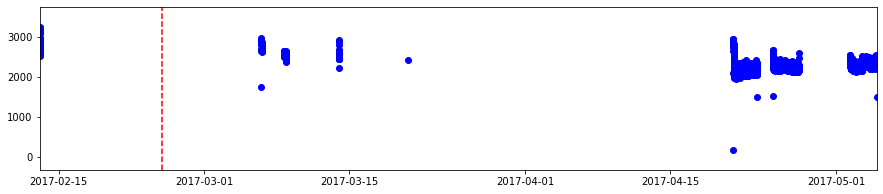


-----------------------------------------------------------------------------------------------------------
27.0


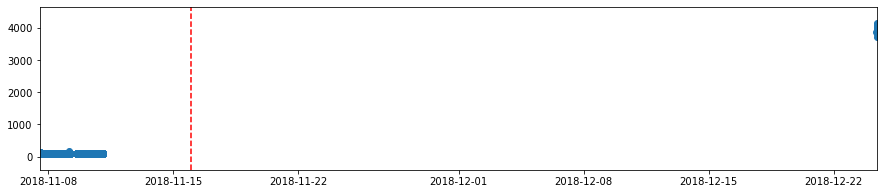

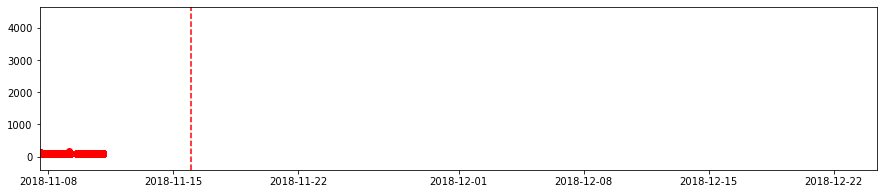

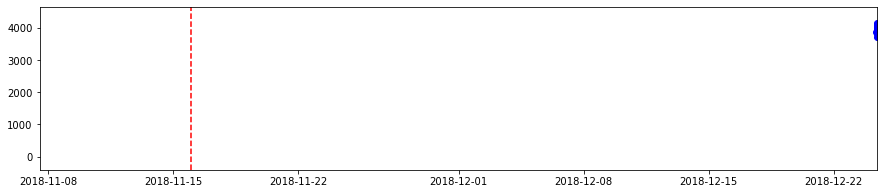

In [24]:
for fault in labeled_data.rotulos_multi.unique()[1:]:

    print("\n-----------------------------------------------------------------------------------------------------------")
    print(fault)
    
    x_clustered, fault_data, init_nota, fim_ordem = fault_cluster(labeled_data, fault, 20, 2)
    plot_cluster(fault_data, x_clustered, 'VT-322', init_nota, fim_ordem)

### PCA

In [25]:
%run ./pca_library.ipynb

In [26]:
data_normal = labeled_data.query("rotulos_multi == 0").copy()
time_data = data_normal[['timestamp']].copy()
data_normal.drop(['rotulos_bin', 'rotulos_multi', 'timestamp'], 1, inplace=True)

PCs:  13


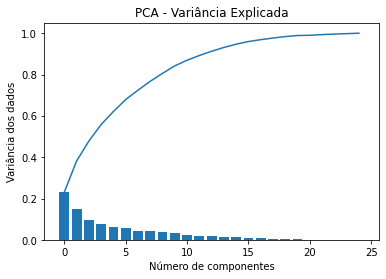

In [28]:
# Todos os trechos de operação normal 
df_train = data_normal.copy()

# Instancia o objeto PCA
pca = PCA(a=0.9)

# Treina o modelo PCA
pca.fit(df_train)

print("PCs: ", pca.a)


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(1.0)

T2: 0.18319559228650137
Q: 0.13774104683195593


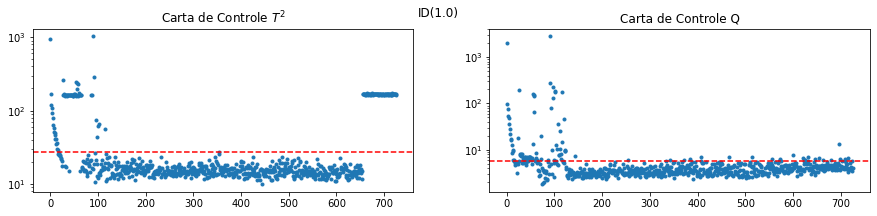

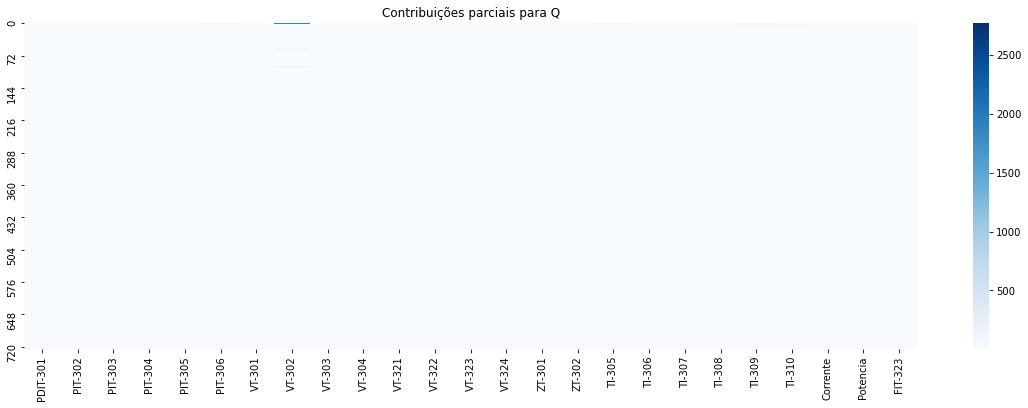


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(2.0)

T2: 0.9727129613433619
Q: 0.21584747245058597


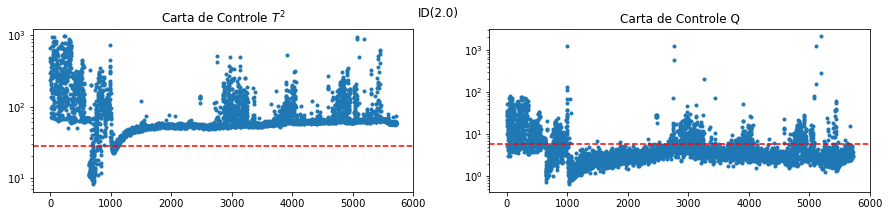

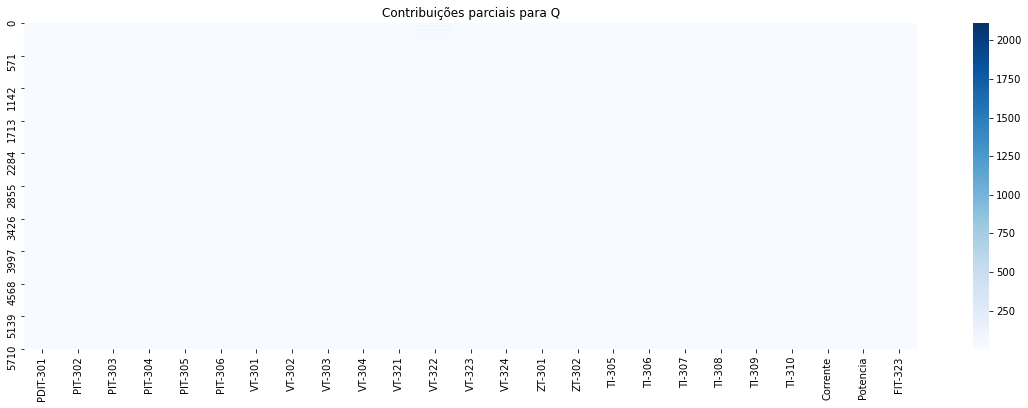


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(6.0)

T2: 0.31982034255259706
Q: 0.1266756925192874


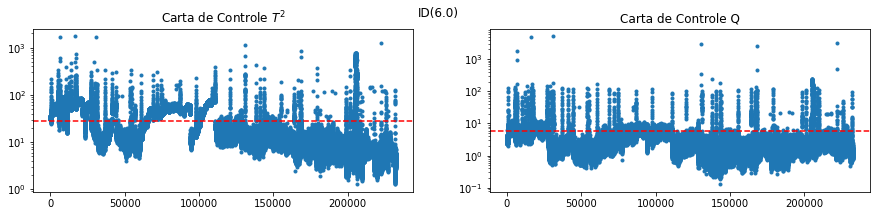

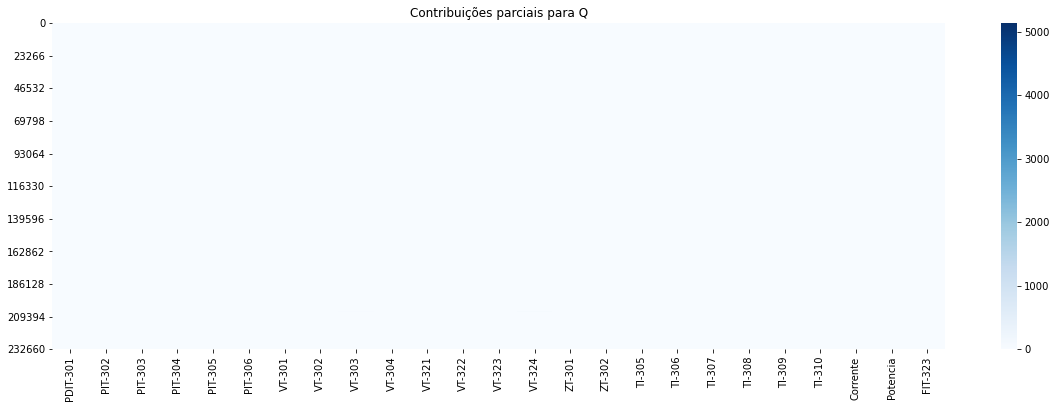


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(7.0)

T2: 0.057966010664825256
Q: 0.05704530632600606


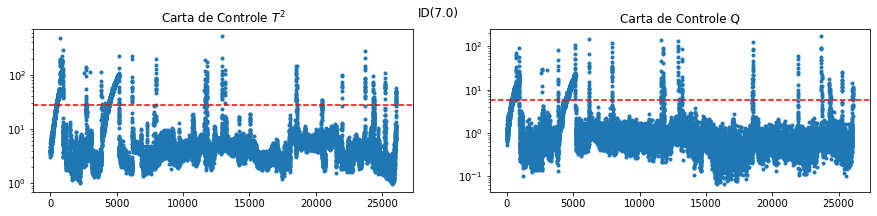

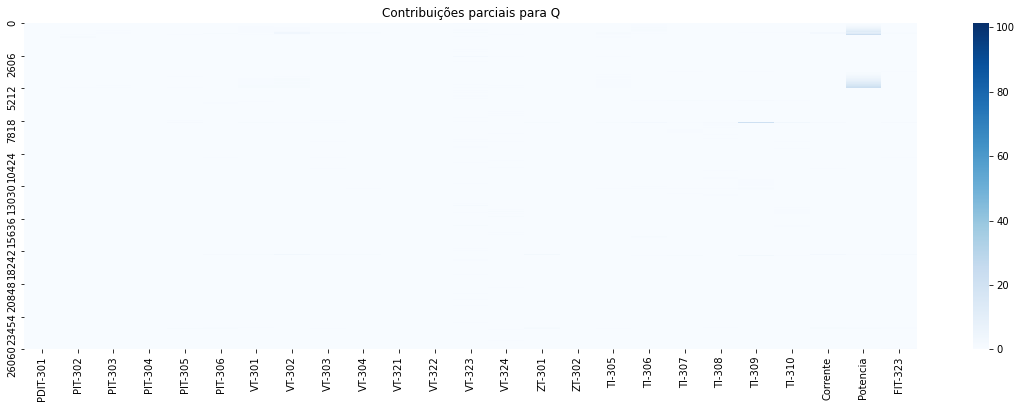


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(8.0)

T2: 0.7068837897853442
Q: 0.7239082161361954


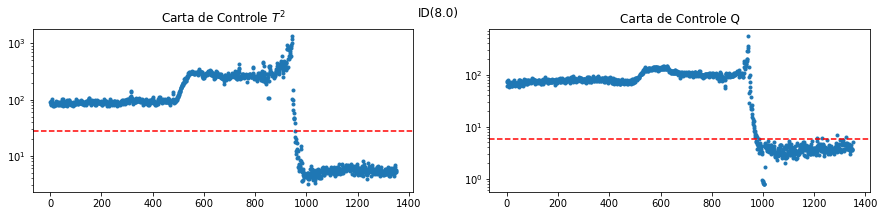

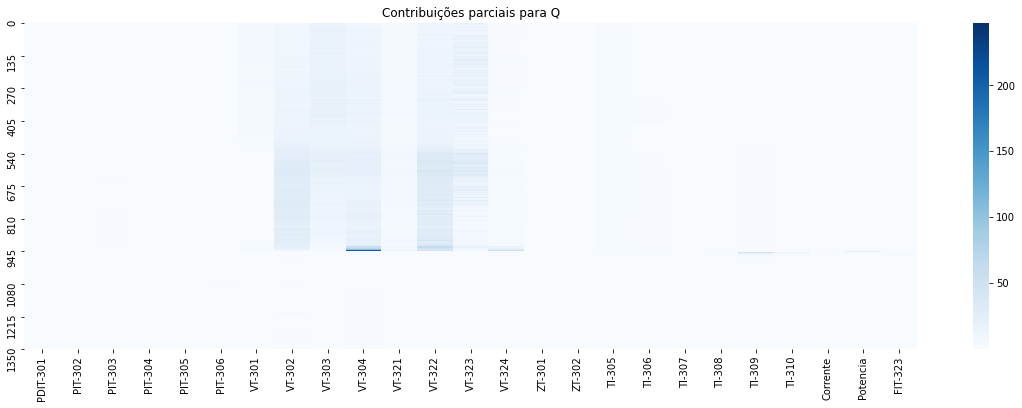


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(9.0)

T2: 0.003771043771043771
Q: 0.005925925925925926


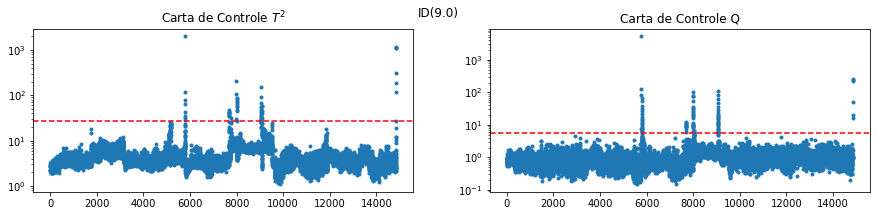

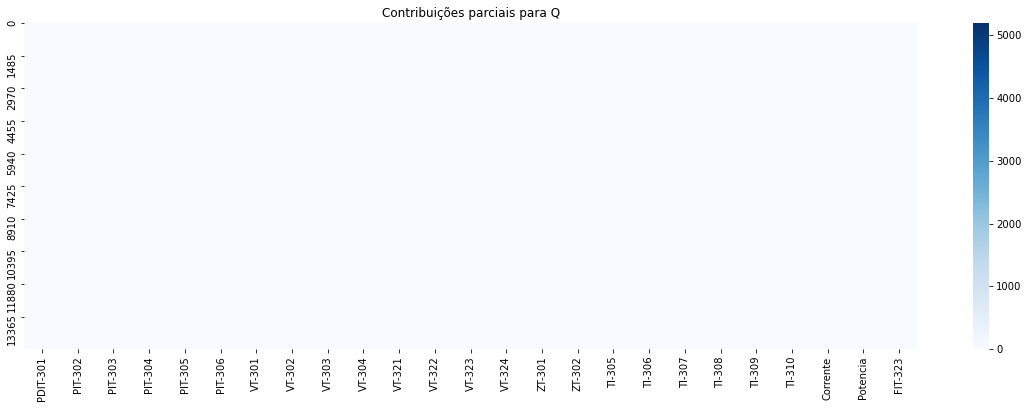


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(10.0)

T2: 0.007348512227442477
Q: 0.022888808577279846


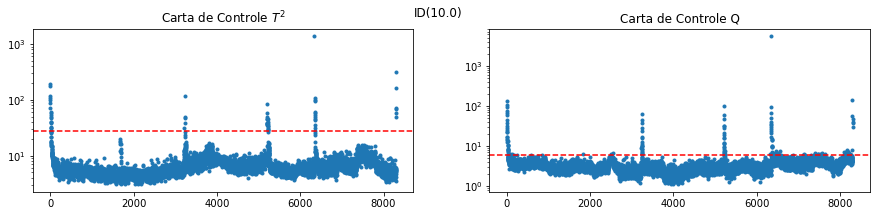

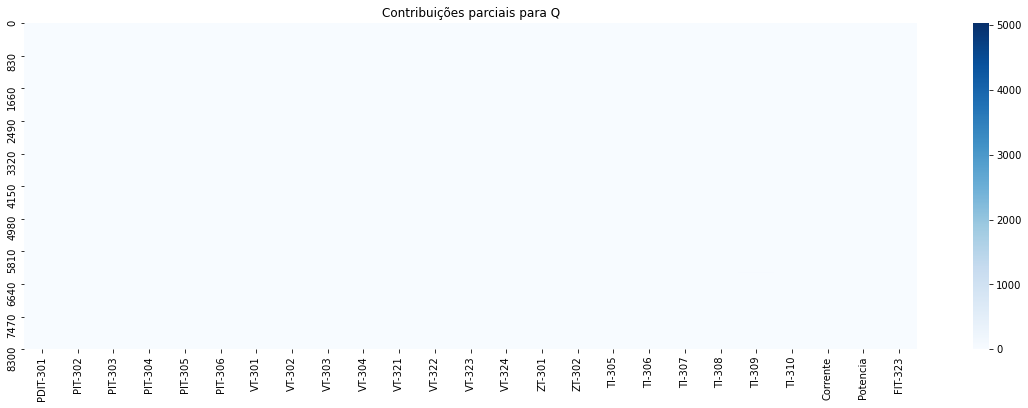


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(11.0)

T2: 0.05987108358525106
Q: 0.6613068393033744


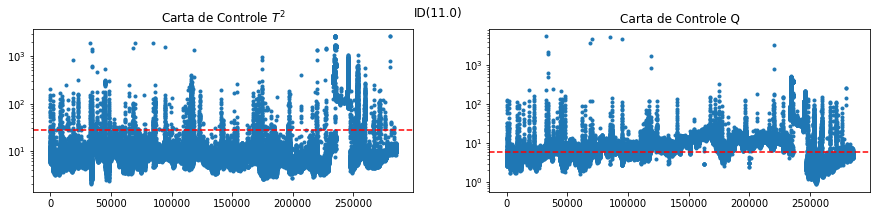

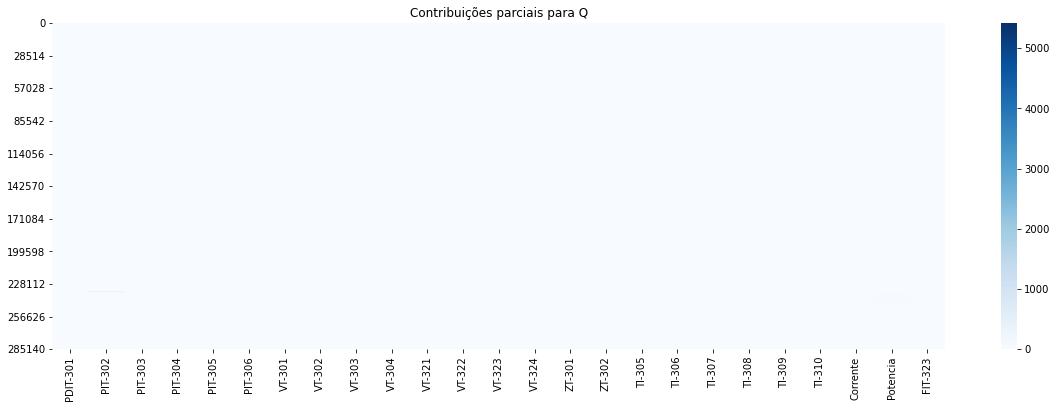


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(17.0)

T2: 0.007616974972796518
Q: 0.5491476242292347


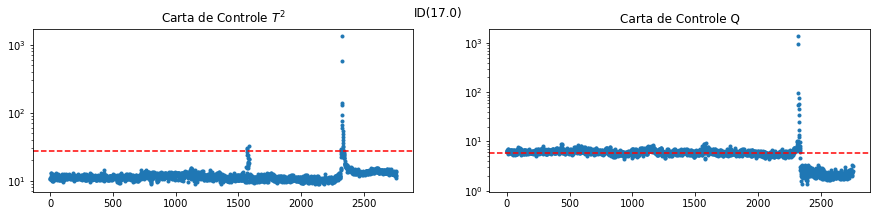

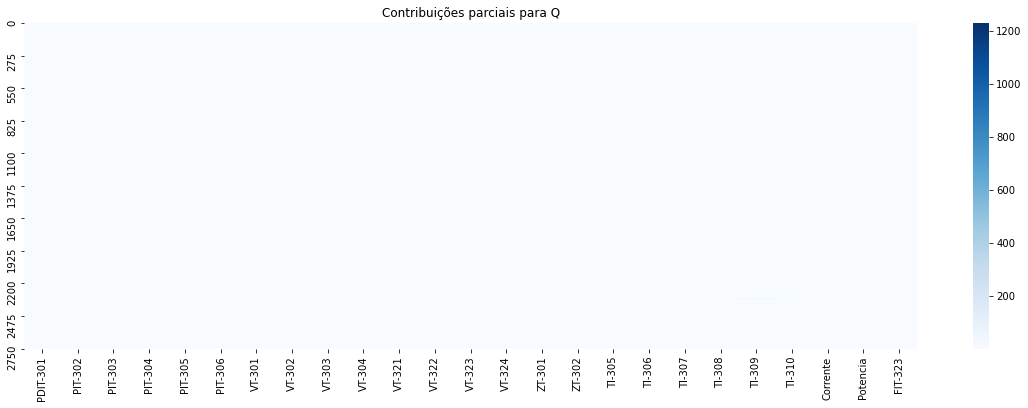


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(18.0)

T2: 0.011779616789681651
Q: 0.01081040781331544


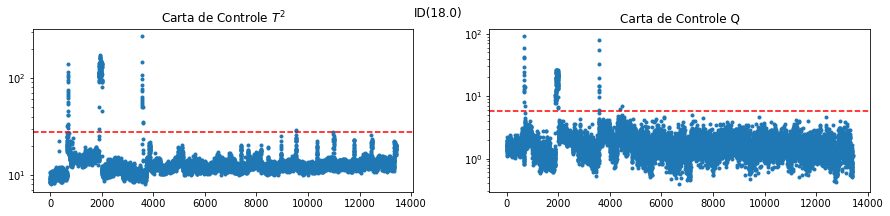

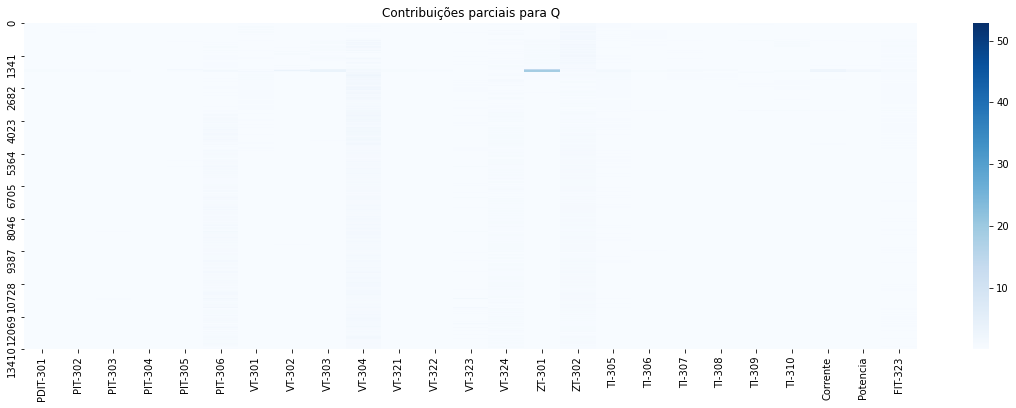


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(19.0)

T2: 1.0
Q: 1.0


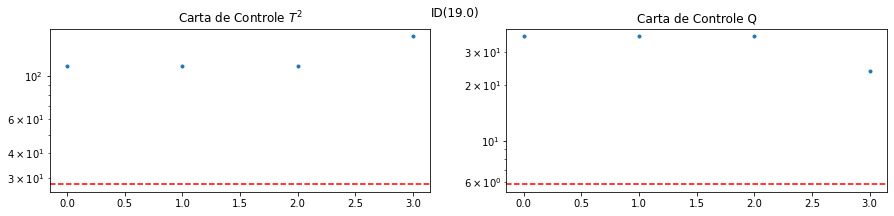

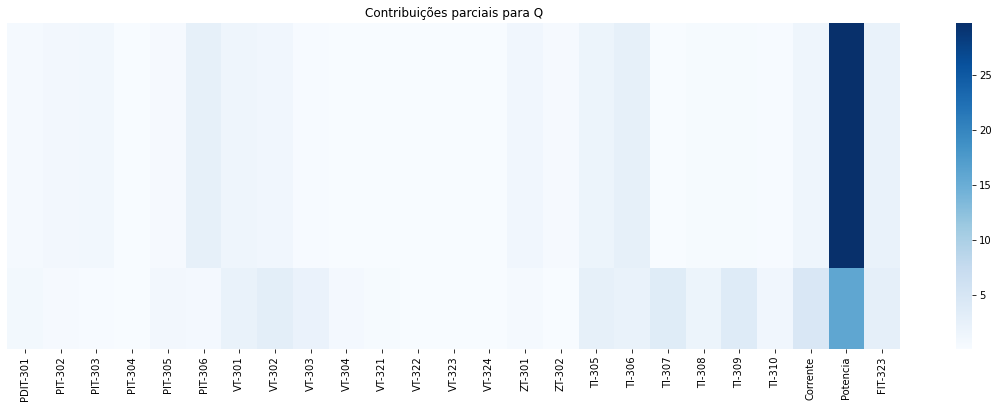


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(20.0)

T2: 0.5512387387387387
Q: 0.6708896396396397


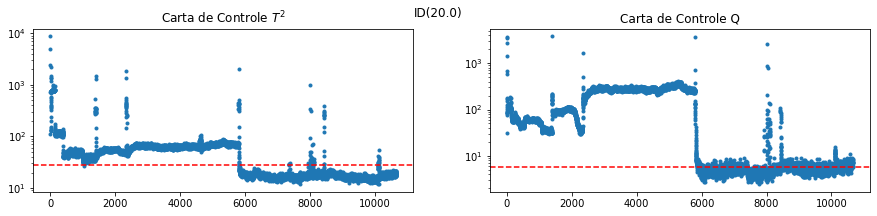

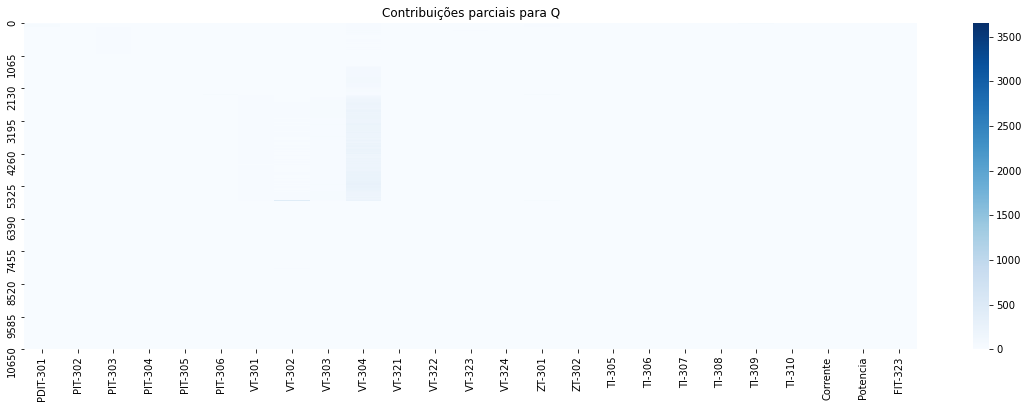


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(24.0)

T2: 0.8007999304408312
Q: 0.9240645740950062


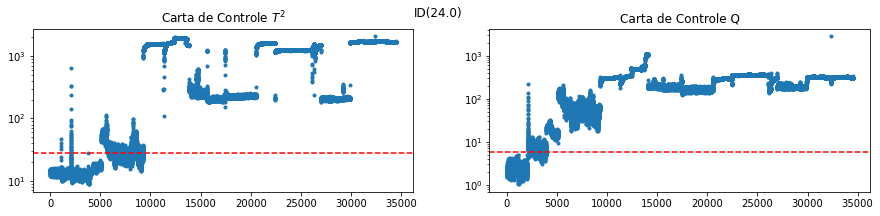

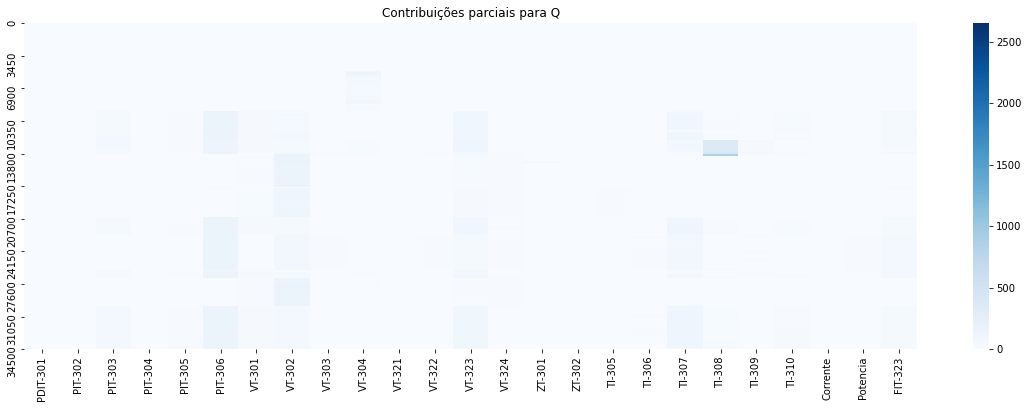


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(25.0)

T2: 0.5491748241863095
Q: 1.0


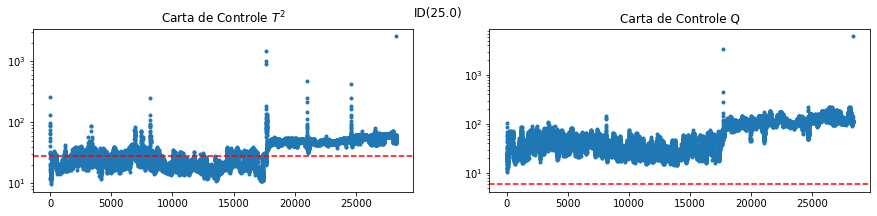

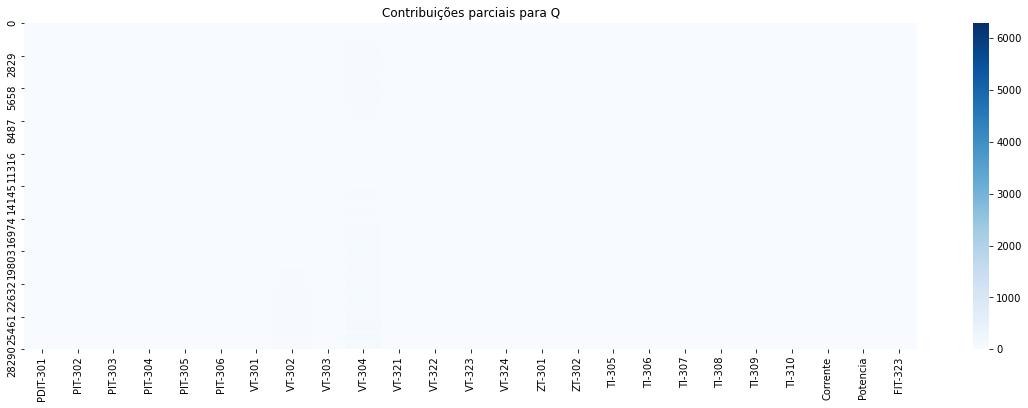


-------------------------------------------------------------------------------
Taxas de detecção de falhas - ID(27.0)

T2: 1.0
Q: 1.0


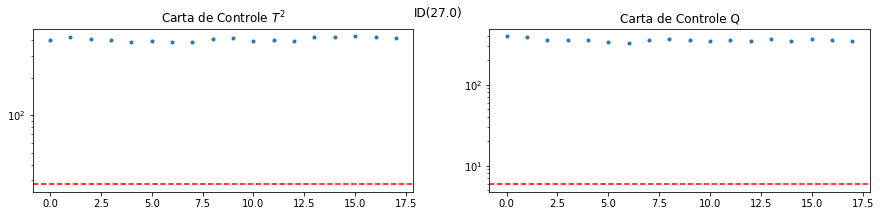

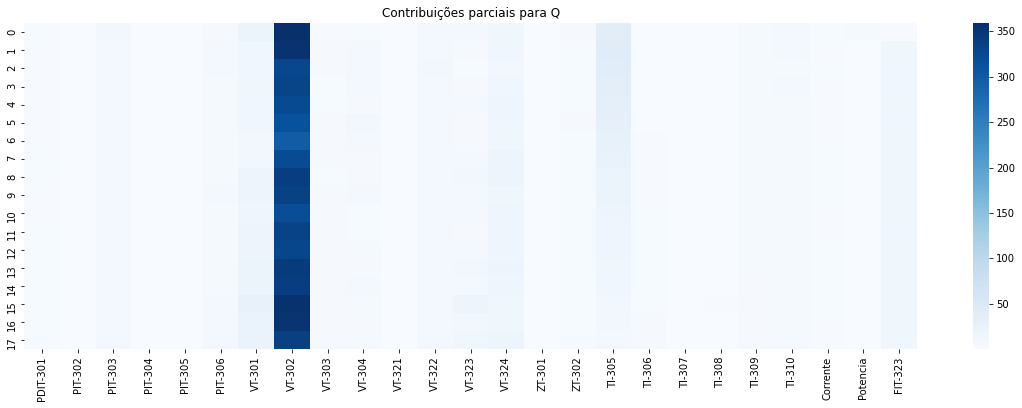

In [32]:
# Aplicação do PCA

fault_id = labeled_data['rotulos_multi'].unique()[1:] 

# Dataframe para armazenar estatísticas calculadas
pca_stats = pd.DataFrame(np.zeros((len(fault_id),3)), columns=['fault', 'T2', 'Q'])

data_to_pca = labeled_data.copy()
data_to_pca.rename(columns={'rotulos_multi': 'STATUS'}, inplace=True)

i=0

for fault in fault_id:
    
    print("\n-------------------------------------------------------------------------------")
    df_test = data_to_pca.query("STATUS == " + str(fault)).copy()
    df_test.drop(['timestamp', 'STATUS', 'rotulos_bin'], 1, inplace=True)
    
    pca.predict(df_test)
    
    print(f'Taxas de detecção de falhas - ID({fault})')

    print(f'\nT2: {(pca.T2>pca.T2_lim).sum()/pca.T2.shape[0]}')
    print(f'Q: {(pca.Q>pca.Q_lim).sum()/pca.Q.shape[0]}')
    
    pca_stats['fault'].iloc[i] = fault
    pca_stats['Q'].iloc[i] = (pca.Q>pca.Q_lim).sum()/pca.Q.shape[0]
    pca_stats['T2'].iloc[i] = (pca.T2>pca.T2_lim).sum()/pca.T2.shape[0]
    i += 1

    pca.plot_control_charts()
    plt.suptitle(f'ID({fault})');

    pca.plot_contributions(columns=df_test.columns)
    plt.show()

In [33]:
pca_stats

,fault,T2,Q
0,1.0,0.183196,0.137741
1,2.0,0.972713,0.215847
2,6.0,0.319820,0.126676
3,7.0,0.057966,0.057045
4,8.0,0.706884,0.723908
5,9.0,0.003771,0.005926
6,10.0,0.007349,0.022889
7,11.0,0.059871,0.661307
8,17.0,0.007617,0.549148
9,18.0,0.011780,0.010810


### Visualização para novos ajustes no banco

Estes ajustes serão implementados na v1 dos rótulos.

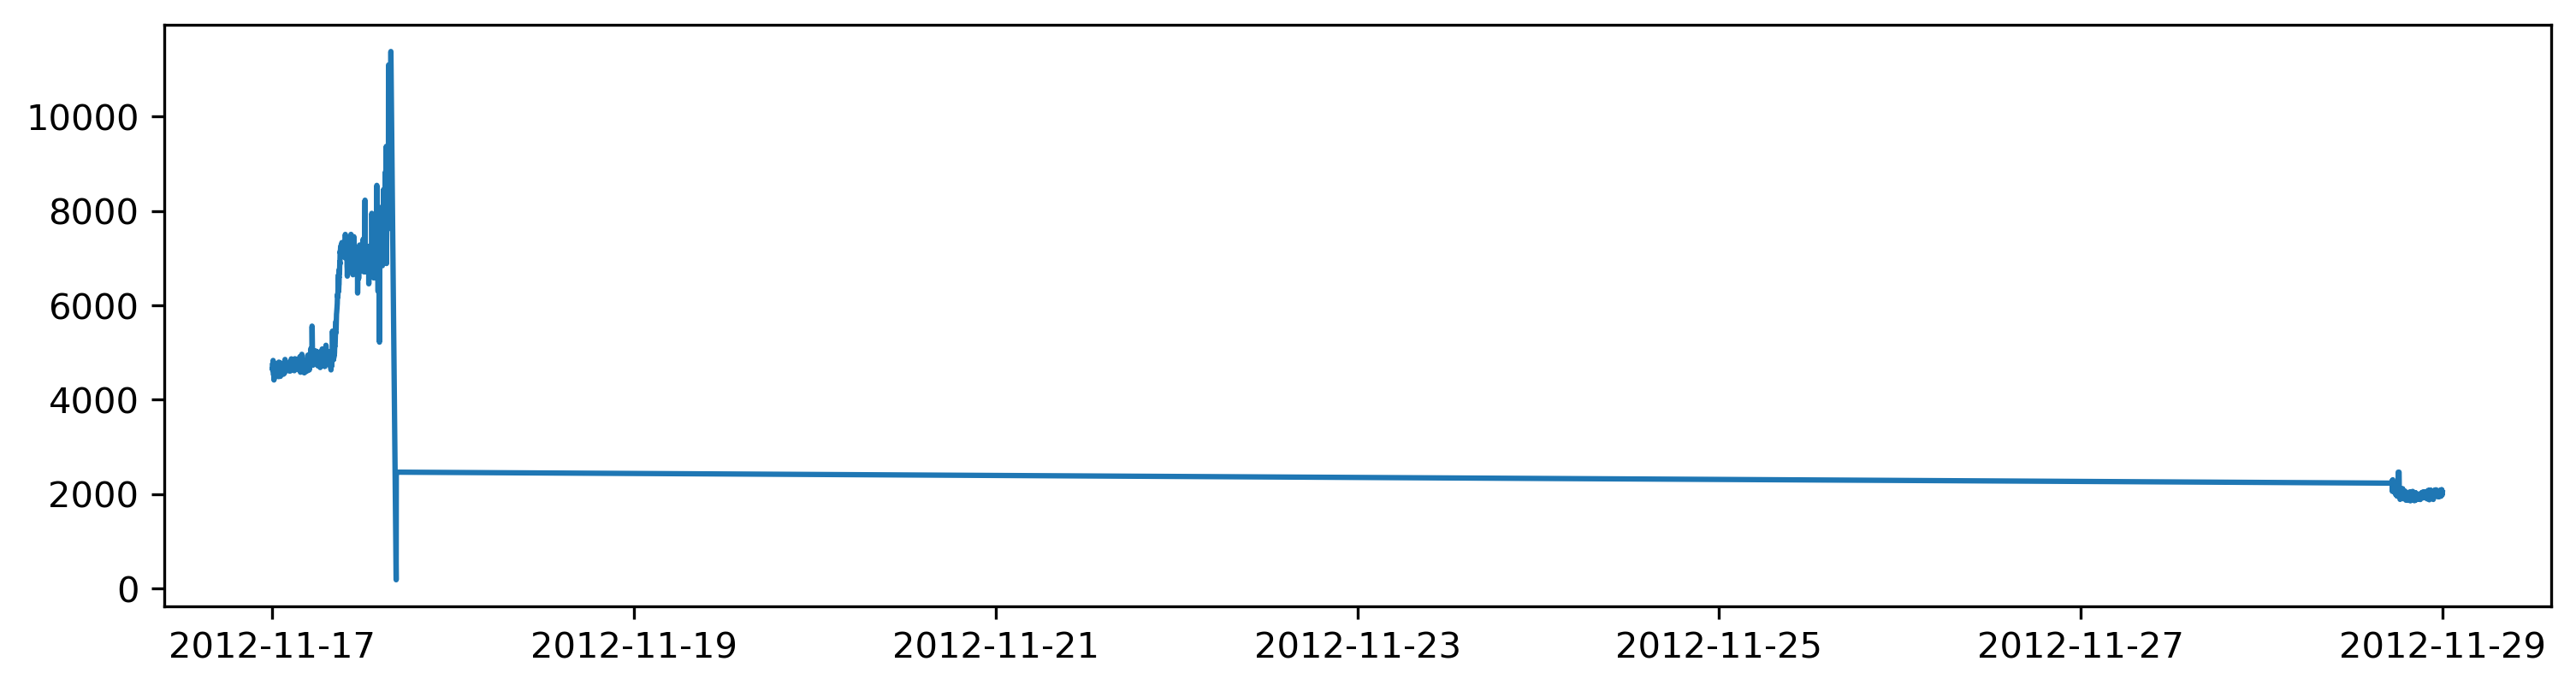

In [74]:
# Falha 8 
# Basta trocar a data de fechamento para 19/11/2012 - retirada desse retorno do final

plt.figure(figsize=(12,3), dpi=300)
plt.plot(labeled_data[labeled_data['rotulos_multi'] == 8]['timestamp'],
         labeled_data[labeled_data['rotulos_multi'] == 8]['VT-322'])

(14850, 28)

(6000, 28)
2013-02-10 18:40:00
2013-02-17 01:30:00


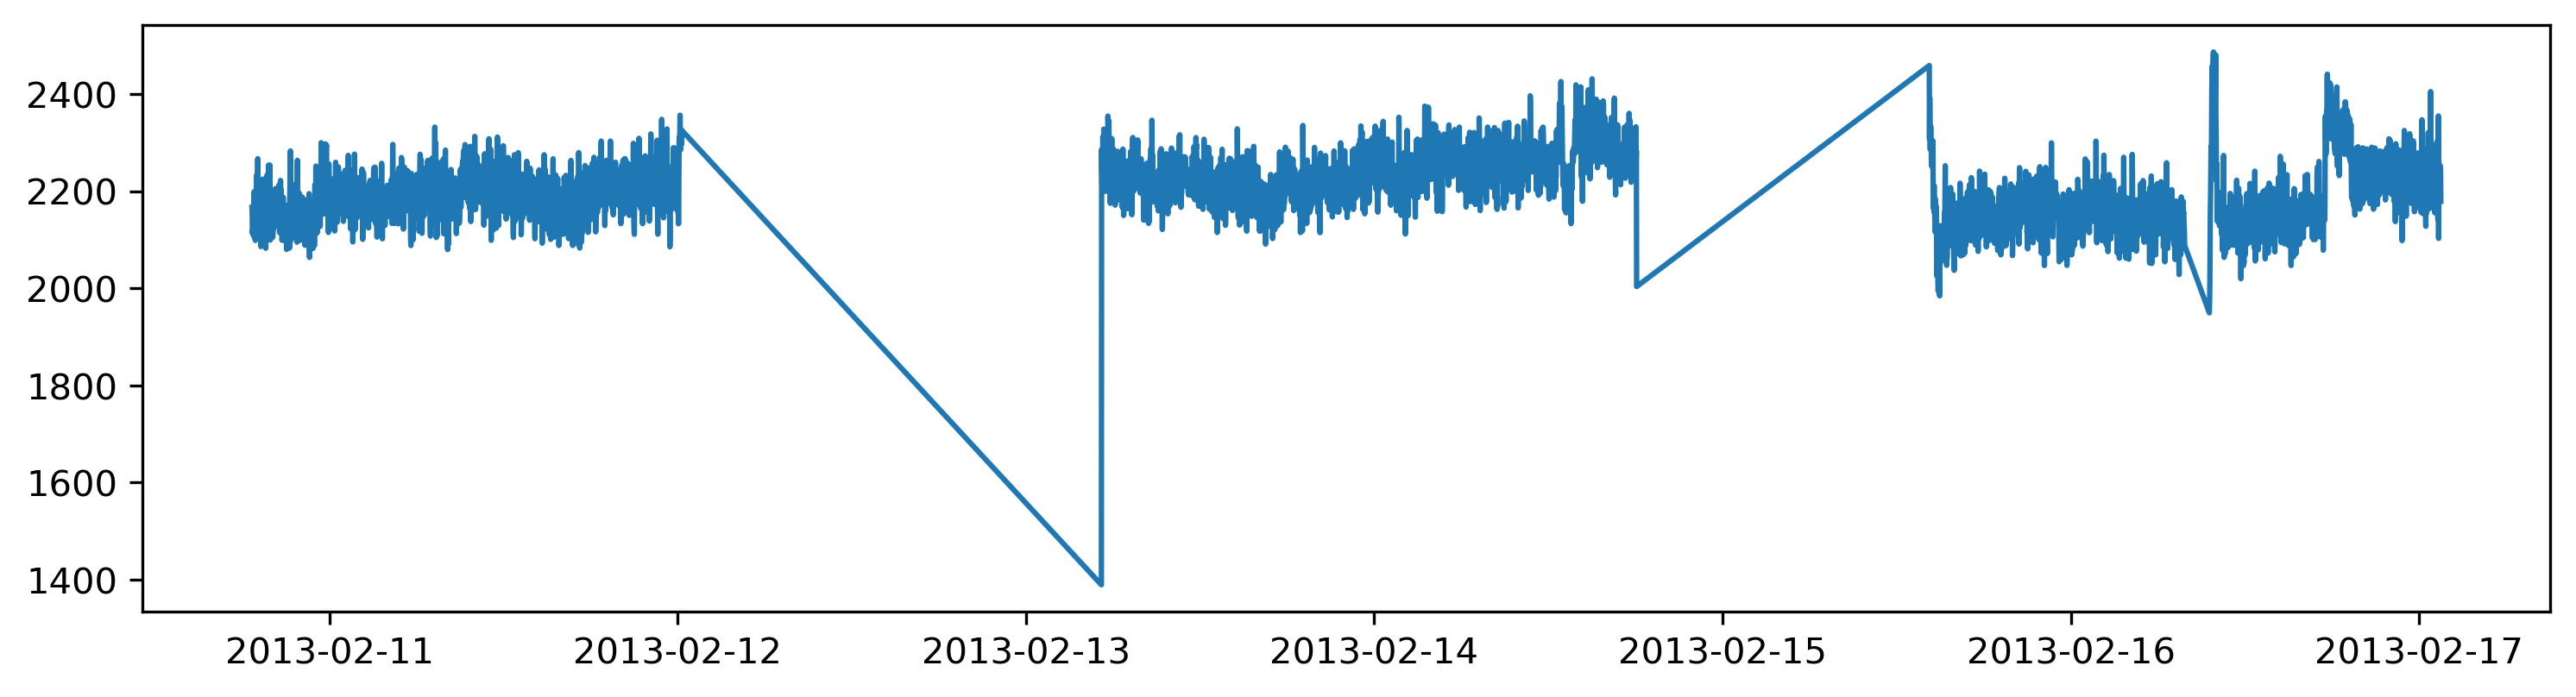

In [84]:
# Falha 9
# Corte no início e no final

print(labeled_data[labeled_data['rotulos_multi'] == 9].shape)

plt.figure(figsize=(12,3), dpi=300)
plt.plot(labeled_data[labeled_data['rotulos_multi'] == 9]['timestamp'][4000:-4850],
         labeled_data[labeled_data['rotulos_multi'] == 9]['VT-322'][4000:-4850]);

print()
print(labeled_data[labeled_data['rotulos_multi'] == 9][4000:-4850].shape)
print(labeled_data[labeled_data['rotulos_multi'] == 9][4000:-4850].timestamp.min())
print(labeled_data[labeled_data['rotulos_multi'] == 9][4000:-4850].timestamp.max())

(2757, 28)

(2257, 28)
2015-05-22 00:00:00
2015-05-23 13:53:00


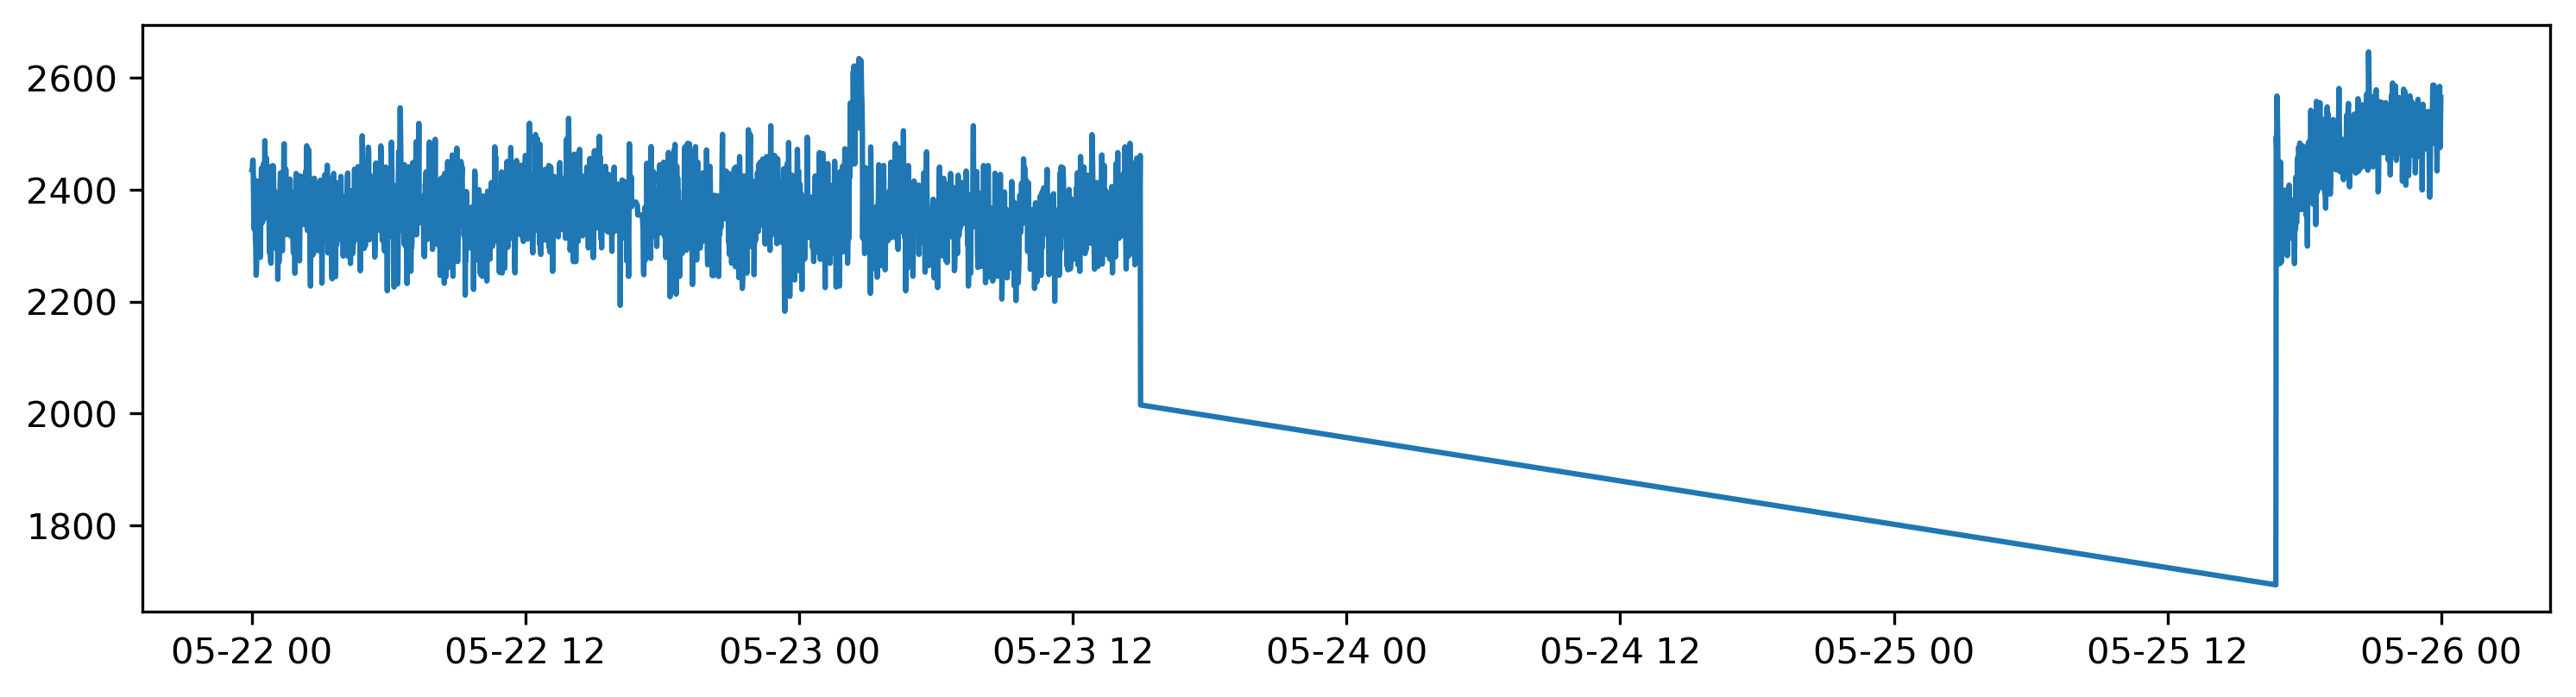

In [93]:
# Falha 17 
# Basta trocar a data de fechamento para 24/05/2012 - retirada desse retorno do final

print(labeled_data[labeled_data['rotulos_multi'] == 17].shape)

plt.figure(figsize=(12,3), dpi=300)
plt.plot(labeled_data[labeled_data['rotulos_multi'] == 17]['timestamp'][:-500],
         labeled_data[labeled_data['rotulos_multi'] == 17]['VT-322'][:-500]);

print()
print(labeled_data[labeled_data['rotulos_multi'] == 17][:-500].shape)
print(labeled_data[labeled_data['rotulos_multi'] == 17][:-500].timestamp.min())
print(labeled_data[labeled_data['rotulos_multi'] == 17][:-500].timestamp.max())

(13413, 28)

(4000, 28)
2015-06-01 00:00:00
2015-06-03 19:51:00


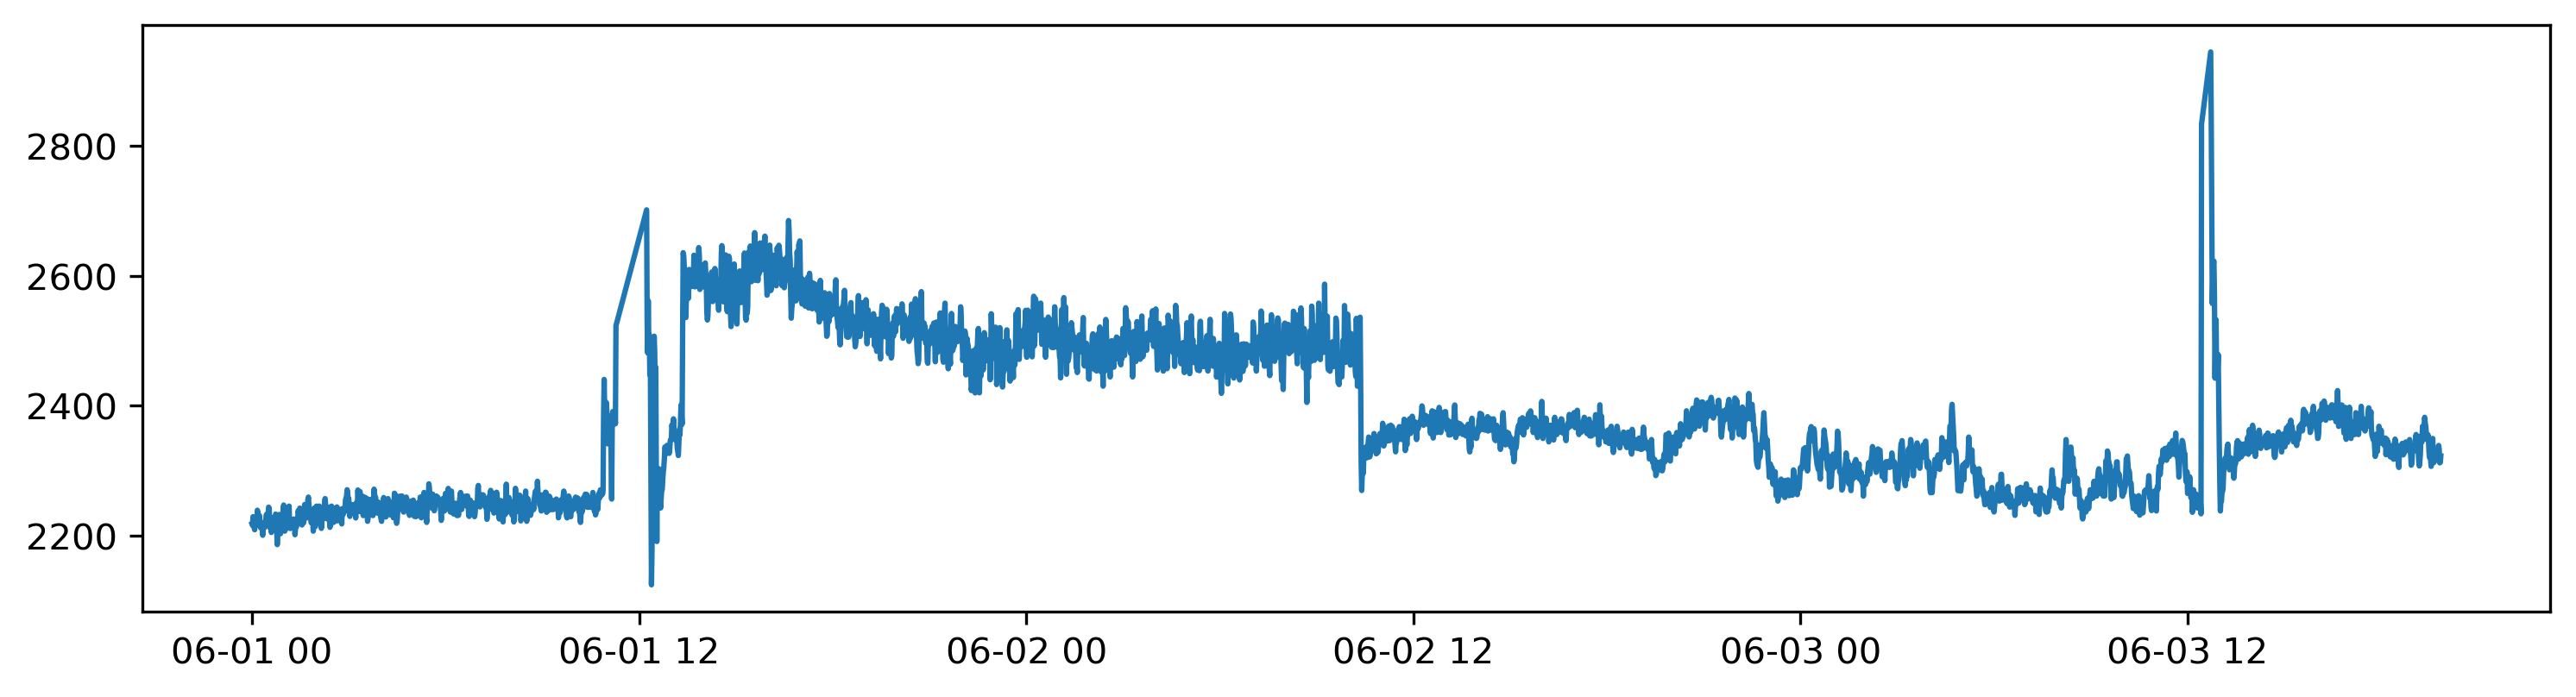

In [99]:
# Falha 18 
# Remoção do final, manutenção apenas dos primeiros 4000 pontos

print(labeled_data[labeled_data['rotulos_multi'] == 18].shape)

plt.figure(figsize=(12,3), dpi=300)
plt.plot(labeled_data[labeled_data['rotulos_multi'] == 18]['timestamp'][:4000],
         labeled_data[labeled_data['rotulos_multi'] == 18]['VT-304'][:4000]);

print()
print(labeled_data[labeled_data['rotulos_multi'] == 18][:4000].shape)
print(labeled_data[labeled_data['rotulos_multi'] == 18][:4000].timestamp.min())
print(labeled_data[labeled_data['rotulos_multi'] == 18][:4000].timestamp.max())

(10656, 28)

(7656, 28)
2015-11-12 10:40:00
2016-10-09 20:58:00


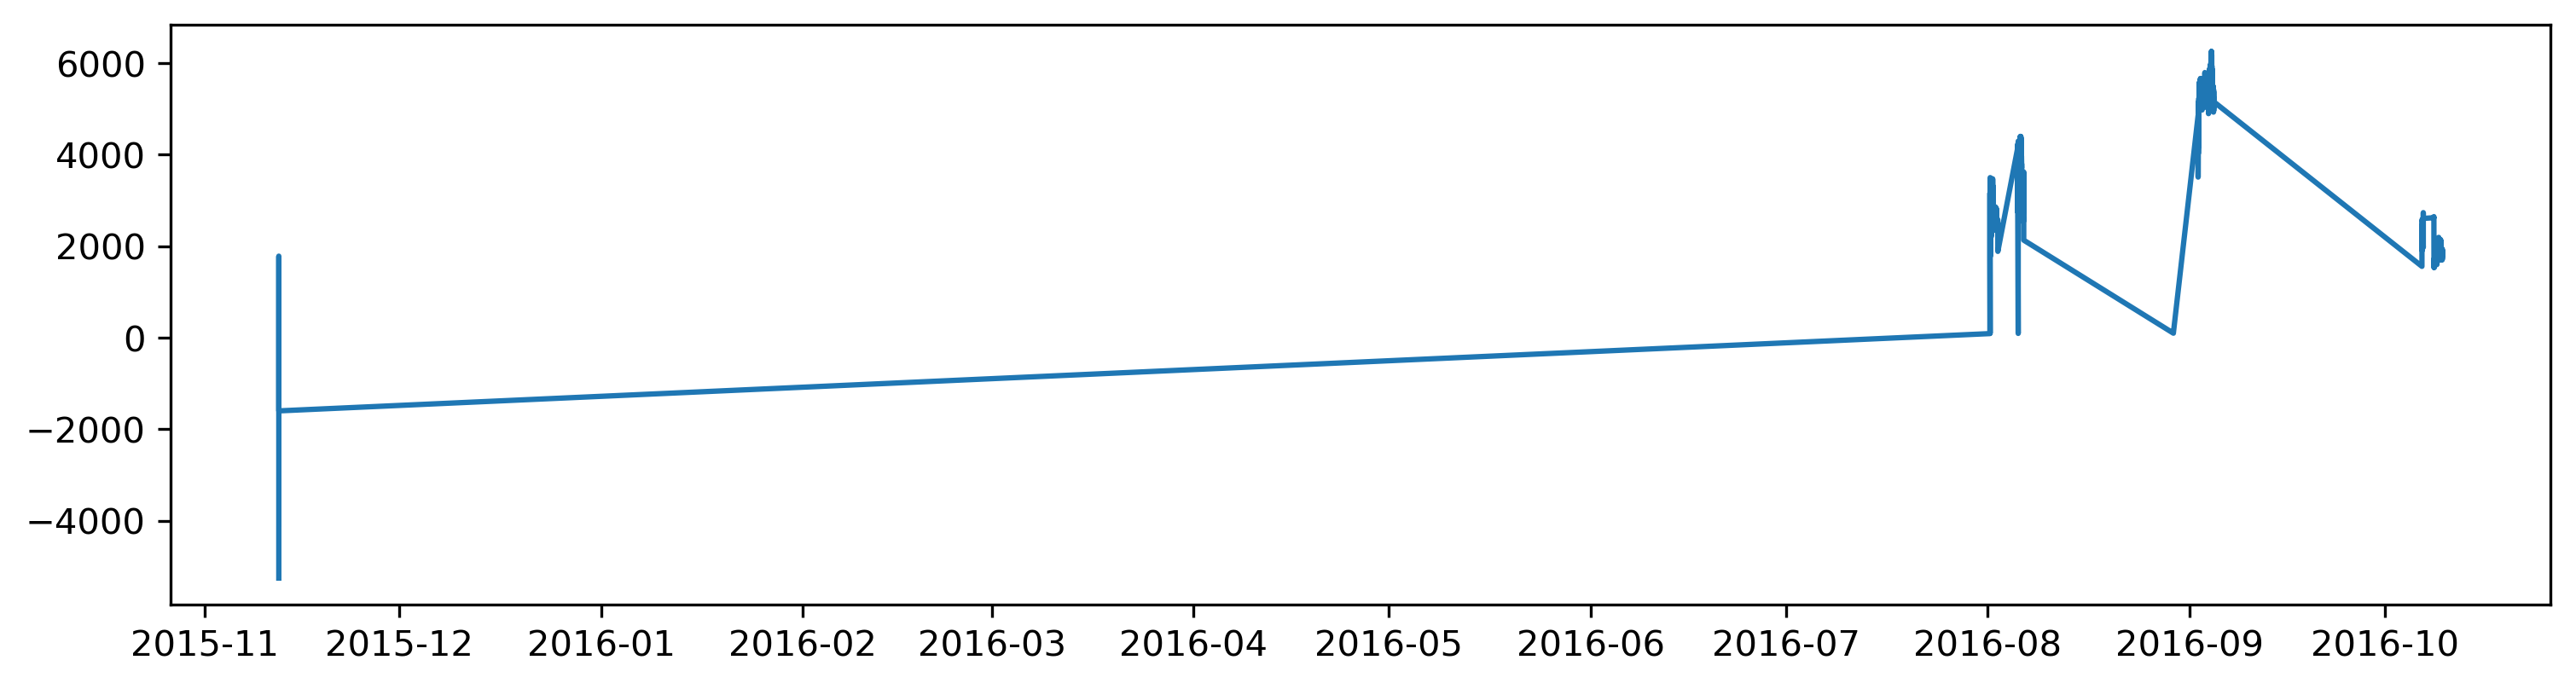

In [104]:
# Falha 20

print(labeled_data[labeled_data['rotulos_multi'] == 20].shape)

plt.figure(figsize=(12,3), dpi=300)
plt.plot(labeled_data[labeled_data['rotulos_multi'] == 20]['timestamp'][:-3000],
         labeled_data[labeled_data['rotulos_multi'] == 20]['VT-304'][:-3000]);

print()
print(labeled_data[labeled_data['rotulos_multi'] == 20][:-3000].shape)
print(labeled_data[labeled_data['rotulos_multi'] == 20][:-3000].timestamp.min())
print(labeled_data[labeled_data['rotulos_multi'] == 20][:-3000].timestamp.max())